In [1]:
# Warning: You must have LaTeX installed

[![Binder](https://mybinder.org/badge_logo.svg)](https://nbviewer.org/github/vicente-gonzalez-ruiz/motion_estimation/blob/main/src/motion_estimation/farneback_ME.ipynb)

[![Colab](https://badgen.net/badge/Launch/on%20Google%20Colab/blue?icon=notebook)](https://colab.research.google.com/github/vicente-gonzalez-ruiz/motion_estimation/blob/main/src/motion_estimation/farneback_ME.ipynb)

# Farnebäck's motion estimation

Farnebäck estimates the dense (1x1) optical flow (with subpixel accuracy) assuming that the frames are similar in texture and the motion is smooth. In general, this last requirement generates motion fields more visually coherent and smoother that in the case of block-based ME algorithms.

In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !apt update
    !apt install imagemagick
    !apt install cm-super
    !apt install dvipng
    !apt install bc
    !apt install texlive-latex-extra
    !apt install texlive-fonts-recommended

In [3]:
!which python

/home/vruiz/.pyenv/shims/python


In [4]:
!pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 5.2 MB/s eta 0:00:00m eta 0:00:010:01:01


In [5]:
try:
    import scipy
except:
    !pip install scipy
    import scipy

In [6]:
try:
    import skimage
except:
    !pip install scikit-image
    import skimage

In [7]:
try:
    import numpy as np
except:
    !pip install numpy
    import numpy as np

In [8]:
try:
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.axes as ax
    import pylab
except:
    !pip install matplotlib
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.axes as ax
    import pylab

plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}" #for \text command
   
%matplotlib inline

In [9]:
try:
    from color_transforms import YCoCg as YUV
except:
    !pip install "color_transforms @ git+https://github.com/vicente-gonzalez-ruiz/color_transforms"
    from color_transforms import YCoCg as YUV

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/vicente-gonzalez-ruiz/color_transforms to /tmp/pip-install-2vcvvfvj/color-transforms_9db19767a0b744a3b8bcc1215644f3ed
  Running command git clone --filter=blob:none --quiet https://github.com/vicente-gonzalez-ruiz/color_transforms /tmp/pip-install-2vcvvfvj/color-transforms_9db19767a0b744a3b8bcc1215644f3ed
  Resolved https://github.com/vicente-gonzalez-ruiz/color_transforms to commit 8dcb71d015db080c1053ea654f528e5ebac32122
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for color_transforms: filename=color_transforms-0.0.1-py3-none-any.whl size=3927 sha256=0b97a8e43493f7fb38dcebc6e37fa8506a193dc2b341ed48e8ecac136a4121d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-ep8jthfj/wheels/23/f6/51/ae1a3f4c5165067ec91459e12edbb0db134721f90fac426d00
Successfully built color_transforms


In [10]:
try:
    from image_IO import image_1 as gray_image
    from image_IO import image_3 as RGB_image
except:
    !pip install "image_IO @ git+https://github.com/vicente-gonzalez-ruiz/image_IO"
    from image_IO import image_1 as gray_image
    from image_IO import image_3 as RGB_image

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/vicente-gonzalez-ruiz/image_IO to /tmp/pip-install-ivmc62ij/image-io_8960ba2bbf3144049f348485a232d514
  Running command git clone --filter=blob:none --quiet https://github.com/vicente-gonzalez-ruiz/image_IO /tmp/pip-install-ivmc62ij/image-io_8960ba2bbf3144049f348485a232d514
  Resolved https://github.com/vicente-gonzalez-ruiz/image_IO to commit 5dff57f270436b2f3de403e9ae1eeb2ee7be5712
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for image_IO: filename=image_IO-0.0.1-py3-none-any.whl size=4699 sha256=15d6f042757b4d47f01f26856be28509150258997458b01e295f18cd5c2d203f
  Stored in directory: /tmp/pip-ephem-wheel-cache-fbltrtee/wheels/20/90/b9/f15d31b7a36249b9fb7b8ab1ad46eb55e45dbdb02ab17bdb7a
Successfully built image_IO


In [11]:
try:
    from information_theory import information
    #from information_theory import distortion
except:
    !pip install "information_theory @ git+https://github.com/vicente-gonzalez-ruiz/information_theory"
    from information_theory import information
    #from information_theory import distortion

In [12]:
try:
    import optical_flow as motion
    import display
    import prediction
except:
    !pip install "motion_estimation @ git+https://github.com/vicente-gonzalez-ruiz/motion_estimation"
    from motion_estimation import optical_flow as motion
    from motion_estimation import display
    from motion_estimation import prediction

OFCA: default number of levels = 3
OFCA: default window size = 33x33
OFCA: default number of iterations = 3
OFCA: extension mode = 1
OFCA: default poly_n 7
OFCA: default poly_sigma 1.5
extension mode = 1


In [13]:
%%bash
if [ -d "$HOME/repos" ]; then
    echo "\"$HOME/repos\" exists"
else
    mkdir ~/repos
    echo Created $HOME/repos
fi

"/home/vruiz/repos" exists


In [14]:
%%bash
if [ -d "$HOME/repos/image_synthesis" ]; then
    cd $HOME/repos/image_synthesis
    echo "$HOME/repos/image_synthesis ... "
    git pull 
else
    cd $HOME/repos
    git clone https://github.com/vicente-gonzalez-ruiz/image_synthesis.git
fi

/home/vruiz/repos/image_synthesis ... 
Ya está actualizado.


## Farnebäck basis transform
Farnebäck's algorithm does not compare pixels, but transform coefficients resulting of convolving the following basis fuctions. This decreases the computational requirements the algorithm.

### No motion

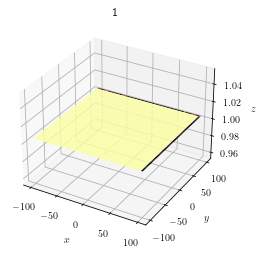

In [15]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = np.sin(tau)**2+np.cos(tau)**2+0.005
ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'1')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

### Constant motion in the X direction

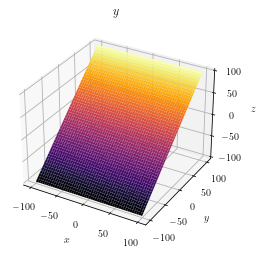

In [16]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = phi

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$y$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp, cmap=cm.inferno)
#fig.colorbar(surf)

### Constant motion in the Y direction

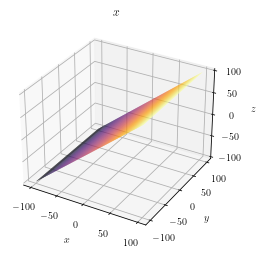

In [17]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = tau

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$x$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

### Contant motion in both directions (at the same time)

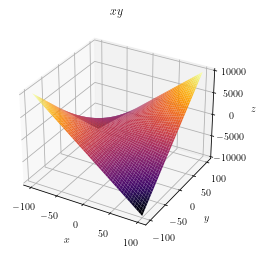

In [18]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = tau*phi

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$xy$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

### Constant acceleration in the Y direction

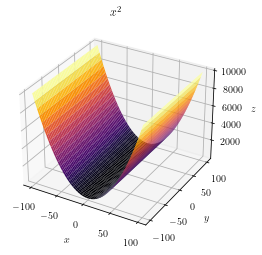

In [19]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = tau*tau

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$x^2$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

### Constant acceleration in the X direction

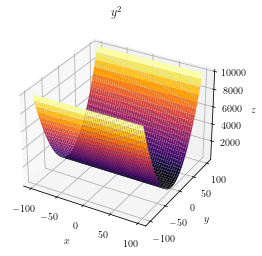

In [20]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = phi*phi

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$y^2$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

## Create a moving-circles sequence
There are two circles, moving horizontally in oposite directions.

In [21]:
%%bash
frames=5
~/repos/image_synthesis/moving_circle.sh -o /tmp/right -x 32 -y 16 -w 64 -h 32 -f $frames -d 10
~/repos/image_synthesis/moving_circle.sh -o /tmp/left -x 32 -y 16 -w 64 -h 32 -f $frames -d 10 -a 0 -b -1
set -x
i=0
while [ $i -le $((frames-1)) ]
do
    ii=$(printf "%03d" $i)
    convert -append /tmp/right${ii}.png /tmp/left${ii}.png /tmp/${ii}.png
    i=$(( $i + 1 ))
done
set -x

/home/vruiz/repos/image_synthesis/moving_circle.sh: parsing: -o /tmp/right -x 32 -y 16 -w 64 -h 32 -f 5 -d 10
output = /tmp/right
Initial X coordinate = 32
Initial Y coordinate = 16
image_width = 64
image_height = 32
frames = 5
diameter = 10


+ i=0
+ '[' 0 -le 4 ']'
++ printf %03d 0
+ ii=000
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 32,16 42,16' -depth 8 /tmp/right000.png
+ i=1
+ '[' 1 -le 4 ']'
++ printf %03d 1
+ ii=001
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 33,16 43,16' -depth 8 /tmp/right001.png
+ i=2
+ '[' 2 -le 4 ']'
++ printf %03d 2
+ ii=002
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 34,16 44,16' -depth 8 /tmp/right002.png
+ i=3
+ '[' 3 -le 4 ']'
++ printf %03d 3
+ ii=003
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 35,16 45,16' -depth 8 /tmp/right003.png
+ i=4
+ '[' 4 -le 4 ']'
++ printf %03d 4
+ ii=004
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 36,16 46,16' -depth 8 /tmp/right004.png
+ i=5
+ '[' 5 -le 4 ']'


/home/vruiz/repos/image_synthesis/moving_circle.sh: parsing: -o /tmp/left -x 32 -y 16 -w 64 -h 32 -f 5 -d 10 -a 0 -b -1
output = /tmp/left
Initial X coordinate = 32
Initial Y coordinate = 16
image_width = 64
image_height = 32
frames = 5
diameter = 10
Y increment = 0
X increment = -1


+ i=0
+ '[' 0 -le 4 ']'
++ printf %03d 0
+ ii=000
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 32,16 42,16' -depth 8 /tmp/left000.png
+ i=1
+ '[' 1 -le 4 ']'
++ printf %03d 1
+ ii=001
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 31,16 41,16' -depth 8 /tmp/left001.png
+ i=2
+ '[' 2 -le 4 ']'
++ printf %03d 2
+ ii=002
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 30,16 40,16' -depth 8 /tmp/left002.png
+ i=3
+ '[' 3 -le 4 ']'
++ printf %03d 3
+ ii=003
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 29,16 39,16' -depth 8 /tmp/left003.png
+ i=4
+ '[' 4 -le 4 ']'
++ printf %03d 4
+ ii=004
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 28,16 38,16' -depth 8 /tmp/left004.png
+ i=5
+ '[' 5 -le 4 ']'
+ i=0
+ '[' 0 -le 4 ']'
++ printf %03d 0
+ ii=000
+ convert -append /tmp/right000.png /tmp/left000.png /tmp/000.png
+ i=1
+ '[' 1 -le 4 ']'
++ printf %03d 1
+ ii=001


## Testing with moving circles (max_abs_motion=1)

In [22]:
R = RGB_image.read("/tmp/000.png")
P = RGB_image.read("/tmp/001.png")
R_Y = YUV.from_RGB(R.astype(np.int16))[...,0]
P_Y = YUV.from_RGB(P.astype(np.int16))[...,0]

[image_3.py:39 read() INFO] /tmp/000.png (64, 64, 3) uint8 len=720 max=255 min=0
[image_3.py:39 read() INFO] /tmp/001.png (64, 64, 3) uint8 len=720 max=255 min=0


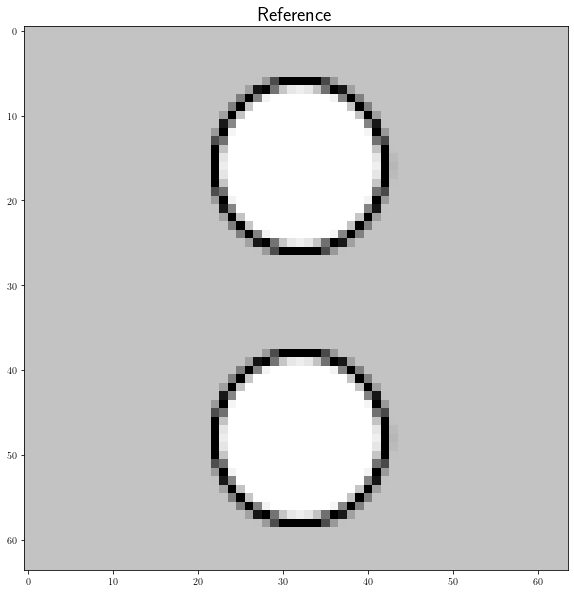

In [23]:
gray_image.show(R_Y, "Reference")

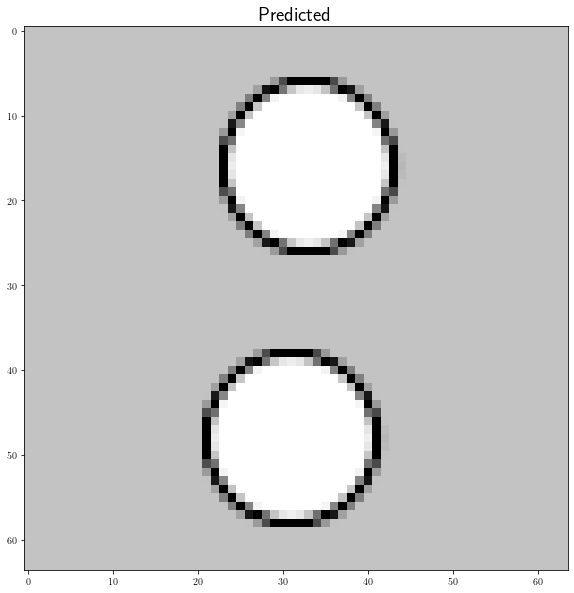

In [24]:
gray_image.show(P_Y, "Predicted")

The top circle moves to the right and the bottom circle moves to the left. Therefore, if we want to generate the predicted frame (bottom) from the reference one (top), all the top MVs (Motion Vectors) related to the circle should be (x=1, y=0), and all the bottom MVs (-1, 0).

In [25]:
initial_MVs = np.zeros((P_Y.shape[0], P_Y.shape[1], 2), dtype=np.float32)
MVs = motion.Farneback_ME(predicted=P_Y, reference=R_Y, initial_MVs=initial_MVs)

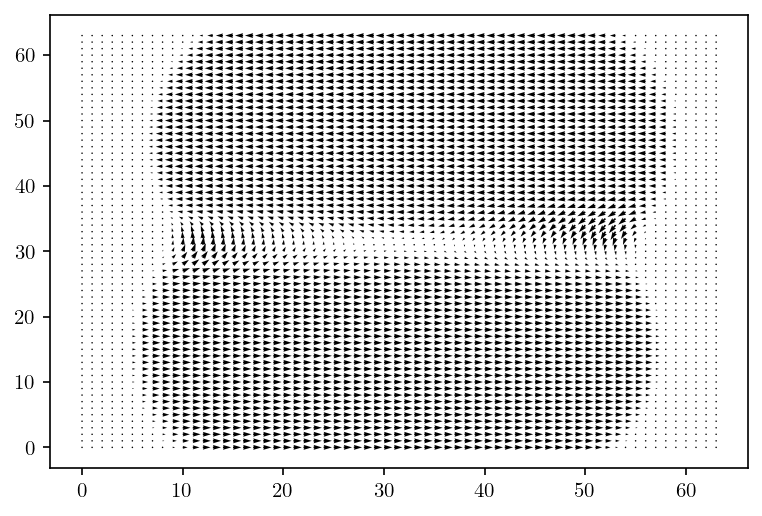

In [26]:
display.show_vectors(MVs[::1, ::1])

In [27]:
hat_P = prediction.make(reference=R, MVs=MVs)

In [28]:
print(R.dtype, MVs.dtype)

uint8 float32


[image_3.py:87 print_stats() INFO] component=0 max=255 min=0 avg=146.77734375
[image_3.py:87 print_stats() INFO] component=1 max=255 min=0 avg=205.49951171875
[image_3.py:87 print_stats() INFO] component=2 max=255 min=0 avg=229.4833984375
[image_3.py:87 print_stats() INFO] component=0 max=255 min=0 avg=146.763671875
[image_3.py:87 print_stats() INFO] component=1 max=255 min=0 avg=205.480712890625
[image_3.py:87 print_stats() INFO] component=2 max=255 min=0 avg=229.4619140625
[image_3.py:87 print_stats() INFO] component=0 max=132 min=125 avg=128.013671875
[image_3.py:87 print_stats() INFO] component=1 max=134 min=123 avg=128.018798828125
[image_3.py:87 print_stats() INFO] component=2 max=135 min=123 avg=128.021484375


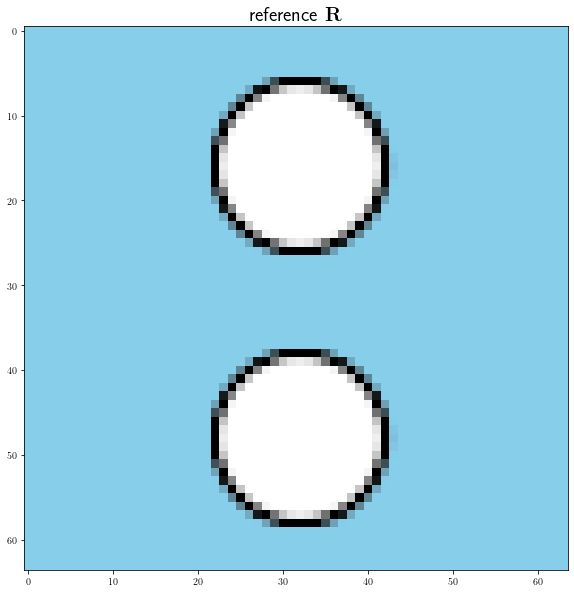

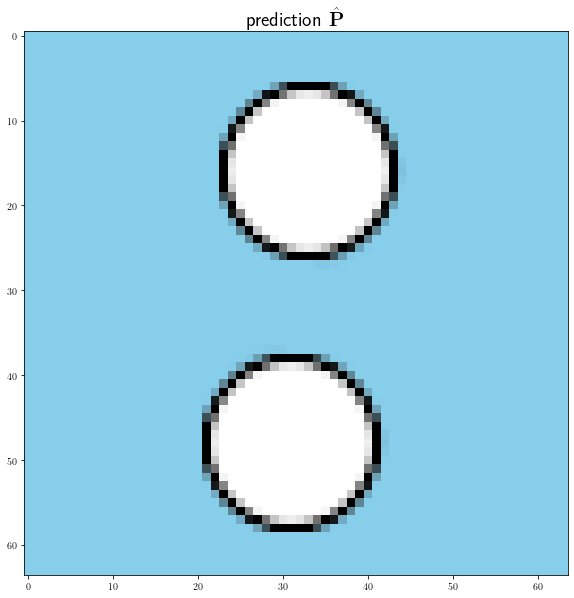

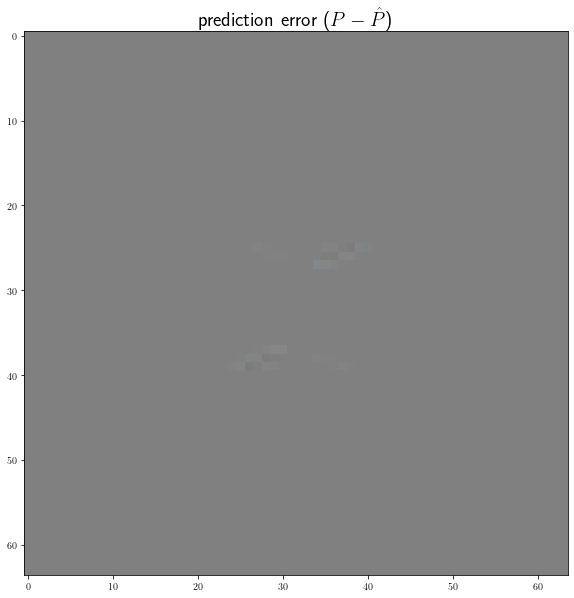

In [29]:
RGB_image.show(R, "reference ${\mathbf R}$")
RGB_image.show(hat_P, "prediction $\hat{\mathbf P}$")
RGB_image.show((P - hat_P + 128).astype(np.uint8), "prediction error ($P-\hat{P}$)")

## Testing with moving circles (max_abs_motion=2)

In [30]:
R = RGB_image.read("/tmp/000.png")
P = RGB_image.read("/tmp/002.png")
R_Y = YUV.from_RGB(R.astype(np.int16))[...,0]
P_Y = YUV.from_RGB(P.astype(np.int16))[...,0]

[image_3.py:39 read() INFO] /tmp/000.png (64, 64, 3) uint8 len=720 max=255 min=0
[image_3.py:39 read() INFO] /tmp/002.png (64, 64, 3) uint8 len=720 max=255 min=0


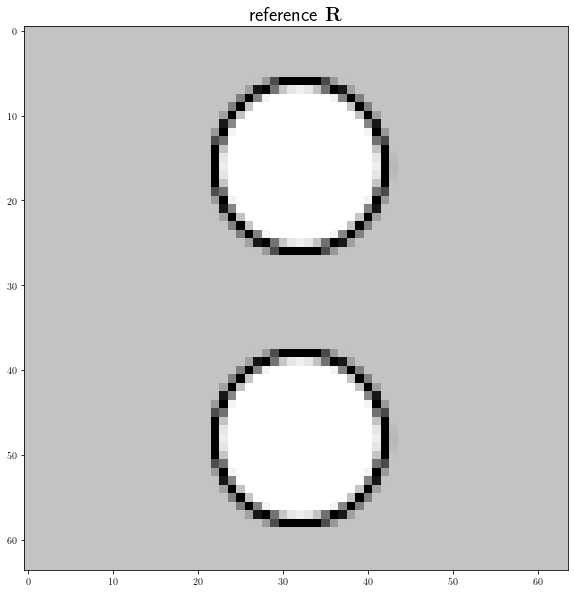

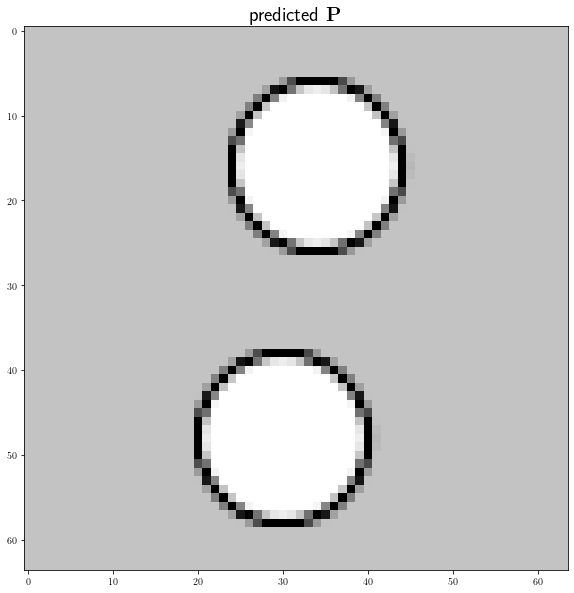

In [31]:
gray_image.show(R_Y, "reference ${\mathbf R}$")
gray_image.show(P_Y, "predicted ${\mathbf P}$")

In [32]:
initial_MVs = np.zeros((P_Y.shape[0], P_Y.shape[1], 2), dtype=np.float32)
MVs = motion.Farneback_ME(predicted=P_Y, reference=R_Y, initial_MVs=initial_MVs)

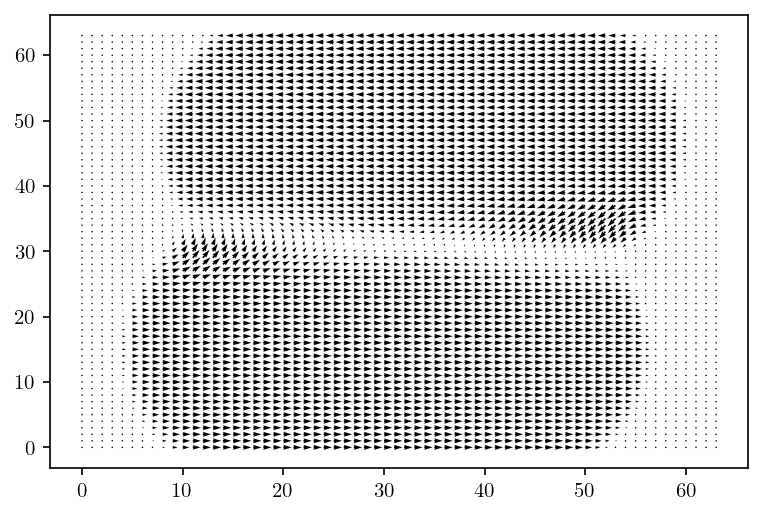

In [33]:
display.show_vectors(MVs[::1, ::1])

[image_3.py:87 print_stats() INFO] component=0 max=255 min=0 avg=146.775146484375
[image_3.py:87 print_stats() INFO] component=1 max=255 min=0 avg=205.486328125
[image_3.py:87 print_stats() INFO] component=2 max=255 min=0 avg=229.463623046875
[image_3.py:87 print_stats() INFO] component=0 max=136 min=118 avg=128.002197265625
[image_3.py:87 print_stats() INFO] component=1 max=140 min=117 avg=128.01318359375
[image_3.py:87 print_stats() INFO] component=2 max=142 min=117 avg=128.019775390625


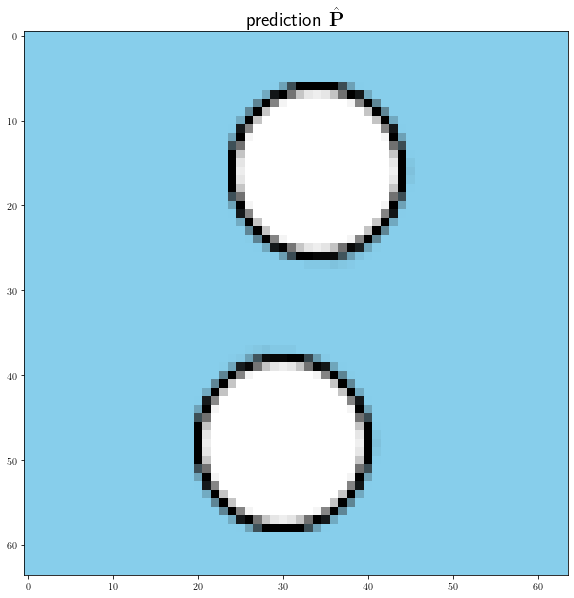

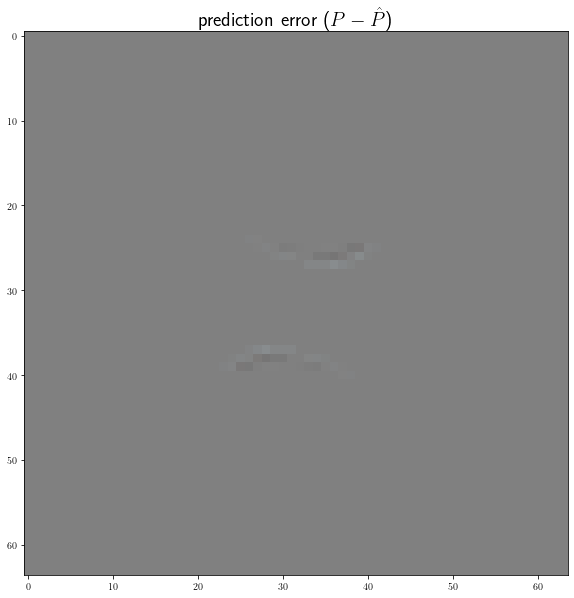

In [34]:
hat_P = prediction.make(R, MVs)
RGB_image.show(hat_P, "prediction $\hat{\mathbf P}$")
RGB_image.show((P - hat_P + 128).astype(np.uint8), "prediction error ($P-\hat{P}$)")

## Even more distance

In [35]:
R = RGB_image.read("/tmp/000.png")
P = RGB_image.read("/tmp/004.png")
R_Y = YUV.from_RGB(R.astype(np.int16))[...,0]
P_Y = YUV.from_RGB(P.astype(np.int16))[...,0]

[image_3.py:39 read() INFO] /tmp/000.png (64, 64, 3) uint8 len=720 max=255 min=0
[image_3.py:39 read() INFO] /tmp/004.png (64, 64, 3) uint8 len=720 max=255 min=0


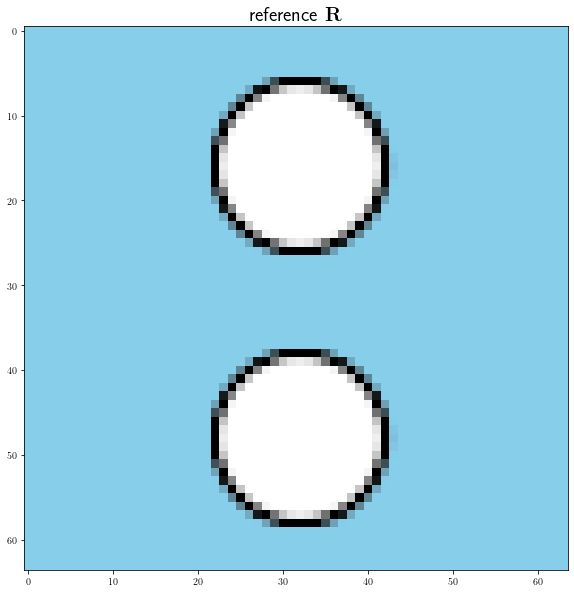

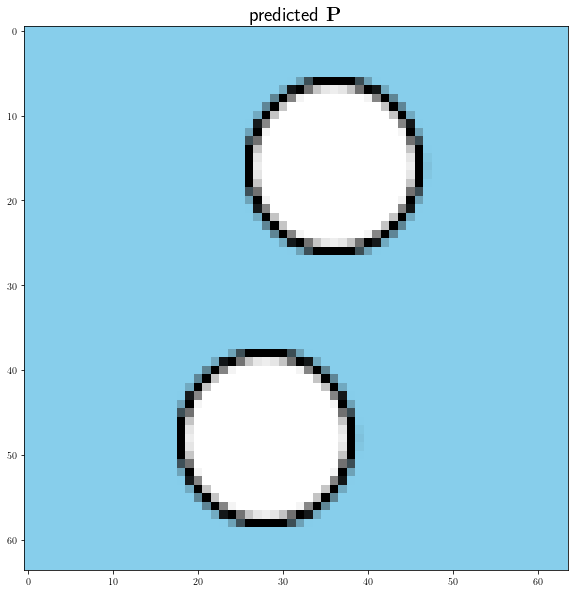

In [36]:
gray_image.show(R, "reference ${\mathbf R}$")
gray_image.show(P, "predicted ${\mathbf P}$")

In [37]:
initial_MVs = np.zeros((P_Y.shape[0], P_Y.shape[1], 2), dtype=np.float32)
MVs = motion.Farneback_ME(predicted=P_Y, reference=R_Y, initial_MVs=initial_MVs)

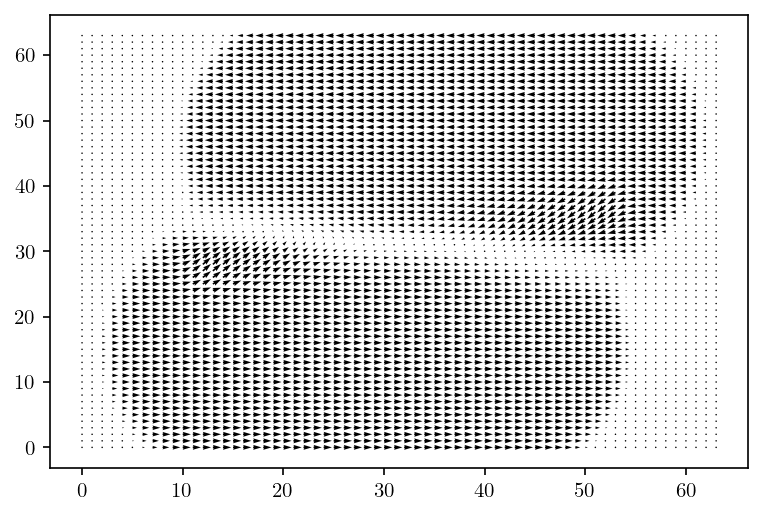

In [38]:
display.show_vectors(MVs[::1, ::1])

[image_3.py:87 print_stats() INFO] component=0 max=255 min=0 avg=146.7734375
[image_3.py:87 print_stats() INFO] component=1 max=255 min=0 avg=205.472412109375
[image_3.py:87 print_stats() INFO] component=2 max=255 min=0 avg=229.44384765625
[image_3.py:87 print_stats() INFO] component=0 max=141 min=111 avg=128.00390625
[image_3.py:87 print_stats() INFO] component=1 max=147 min=109 avg=128.027099609375
[image_3.py:87 print_stats() INFO] component=2 max=150 min=109 avg=128.03955078125


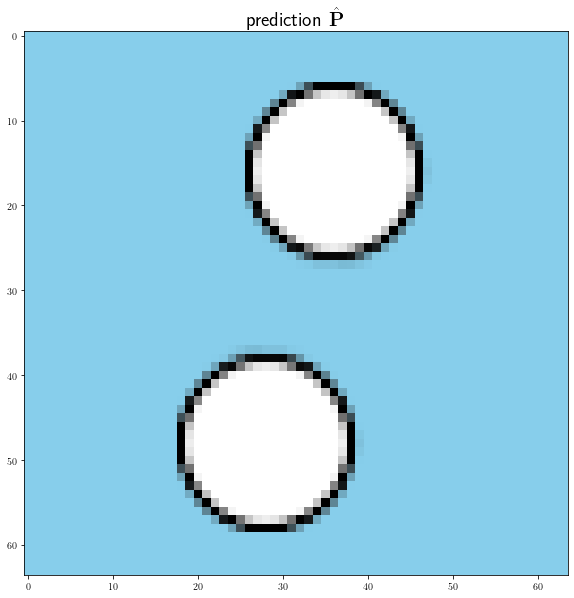

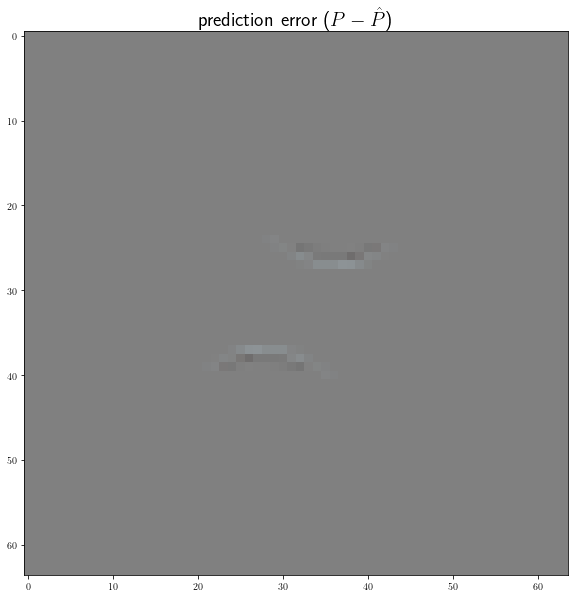

In [39]:
hat_P = prediction.make(R, MVs)
RGB_image.show(hat_P, "prediction $\hat{\mathbf P}$")
RGB_image.show((P - hat_P + 128).astype(np.uint8), "prediction error ($P-\hat{P}$)")

### Conclusion
Farnebäck's ME does not always minimizes the L$_2$ distance.

## Tile of Stockholm

In [40]:
%%bash
URL="https://hpca.ual.es/~vruiz/videos/"
sequence="stockholm_1280x768x50x420x578.avi"
output_prefix="/tmp/original_"
number_of_frames=16
first_frame=2
~/repos/image_synthesis/extract_frames.sh -u $URL -s $sequence -o $output_prefix -n $number_of_frames -f $first_frame

URL = https://hpca.ual.es/~vruiz/videos/
sequence file name = stockholm_1280x768x50x420x578.avi
output prefix = /tmp/original_
number of frames to extract = 16
first frame to extract = 2


--2023-02-03 10:19:16--  https://hpca.ual.es/~vruiz/videos//stockholm_1280x768x50x420x578.avi
Cargado certificado CA '/etc/ssl/certs/ca-certificates.crt'
Resolviendo hpca.ual.es (hpca.ual.es)... 150.214.150.42
Conectando con hpca.ual.es (hpca.ual.es)[150.214.150.42]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 357255516 (341M) [video/x-msvideo]
Grabando a: «/tmp/stockholm_1280x768x50x420x578.avi»

     0K .......... .......... .......... .......... ..........  0% 4,88M 70s
    50K .......... .......... .......... .......... ..........  0% 7,83M 57s
   100K .......... .......... .......... .......... ..........  0% 13,1M 46s
   150K .......... .......... .......... .......... ..........  0% 69,5M 36s
   200K .......... .......... .......... .......... ..........  0% 8,98M 36s
   250K .......... .......... .......... .......... ..........  0%  180M 31s
   300K .......... .......... .......... .......... ..........  0%  125M 27s
   350K .......... .....

  5050K .......... .......... .......... .......... ..........  1% 20,3M 10s
  5100K .......... .......... .......... .......... ..........  1% 83,7M 10s
  5150K .......... .......... .......... .......... ..........  1%  105M 10s
  5200K .......... .......... .......... .......... ..........  1% 37,4M 10s
  5250K .......... .......... .......... .......... ..........  1% 19,8M 10s
  5300K .......... .......... .......... .......... ..........  1% 64,1M 10s
  5350K .......... .......... .......... .......... ..........  1% 21,8M 10s
  5400K .......... .......... .......... .......... ..........  1% 77,8M 10s
  5450K .......... .......... .......... .......... ..........  1% 2,64M 11s
  5500K .......... .......... .......... .......... ..........  1% 16,2M 11s
  5550K .......... .......... .......... .......... ..........  1%  164M 11s
  5600K .......... .......... .......... .......... ..........  1%  113M 11s
  5650K .......... .......... .......... .......... ..........  1%  150M 11s

 10400K .......... .......... .......... .......... ..........  2%  141M 10s
 10450K .......... .......... .......... .......... ..........  3%  136M 10s
 10500K .......... .......... .......... .......... ..........  3% 47,7M 10s
 10550K .......... .......... .......... .......... ..........  3% 15,2M 10s
 10600K .......... .......... .......... .......... ..........  3%  139M 10s
 10650K .......... .......... .......... .......... ..........  3% 64,1M 10s
 10700K .......... .......... .......... .......... ..........  3% 5,99M 10s
 10750K .......... .......... .......... .......... ..........  3%  104M 10s
 10800K .......... .......... .......... .......... ..........  3% 37,6M 10s
 10850K .......... .......... .......... .......... ..........  3%  113M 10s
 10900K .......... .......... .......... .......... ..........  3%  129M 10s
 10950K .......... .......... .......... .......... ..........  3% 3,09M 10s
 11000K .......... .......... .......... .......... ..........  3%  141M 10s

 15750K .......... .......... .......... .......... ..........  4%  189M 10s
 15800K .......... .......... .......... .......... ..........  4%  136M 10s
 15850K .......... .......... .......... .......... ..........  4%  124M 10s
 15900K .......... .......... .......... .......... ..........  4%  139M 10s
 15950K .......... .......... .......... .......... ..........  4% 59,7M 10s
 16000K .......... .......... .......... .......... ..........  4% 19,9M 10s
 16050K .......... .......... .......... .......... ..........  4% 71,9M 10s
 16100K .......... .......... .......... .......... ..........  4% 22,9M 10s
 16150K .......... .......... .......... .......... ..........  4% 34,6M 10s
 16200K .......... .......... .......... .......... ..........  4% 29,9M 10s
 16250K .......... .......... .......... .......... ..........  4% 16,4M 10s
 16300K .......... .......... .......... .......... ..........  4%  138M 10s
 16350K .......... .......... .......... .......... ..........  4% 48,2M 10s

 21100K .......... .......... .......... .......... ..........  6%  198M 10s
 21150K .......... .......... .......... .......... ..........  6% 77,0M 10s
 21200K .......... .......... .......... .......... ..........  6% 89,3M 10s
 21250K .......... .......... .......... .......... ..........  6% 14,1M 10s
 21300K .......... .......... .......... .......... ..........  6%  154M 10s
 21350K .......... .......... .......... .......... ..........  6%  186M 10s
 21400K .......... .......... .......... .......... ..........  6%  156M 10s
 21450K .......... .......... .......... .......... ..........  6%  200M 10s
 21500K .......... .......... .......... .......... ..........  6%  187M 10s
 21550K .......... .......... .......... .......... ..........  6% 18,9M 10s
 21600K .......... .......... .......... .......... ..........  6% 98,3M 10s
 21650K .......... .......... .......... .......... ..........  6% 94,8M 10s
 21700K .......... .......... .......... .......... ..........  6% 55,8M 10s

 26450K .......... .......... .......... .......... ..........  7%  123M 9s
 26500K .......... .......... .......... .......... ..........  7%  213M 9s
 26550K .......... .......... .......... .......... ..........  7% 40,8M 9s
 26600K .......... .......... .......... .......... ..........  7% 72,4M 9s
 26650K .......... .......... .......... .......... ..........  7% 26,0M 9s
 26700K .......... .......... .......... .......... ..........  7% 31,8M 9s
 26750K .......... .......... .......... .......... ..........  7% 60,8M 9s
 26800K .......... .......... .......... .......... ..........  7% 18,2M 9s
 26850K .......... .......... .......... .......... ..........  7% 39,4M 9s
 26900K .......... .......... .......... .......... ..........  7%  110M 9s
 26950K .......... .......... .......... .......... ..........  7% 18,8M 9s
 27000K .......... .......... .......... .......... ..........  7% 49,3M 9s
 27050K .......... .......... .......... .......... ..........  7% 11,3M 9s
 27100K ....

 31850K .......... .......... .......... .......... ..........  9% 7,37M 9s
 31900K .......... .......... .......... .......... ..........  9%  191M 9s
 31950K .......... .......... .......... .......... ..........  9%  162M 9s
 32000K .......... .......... .......... .......... ..........  9% 71,3M 9s
 32050K .......... .......... .......... .......... ..........  9% 83,2M 9s
 32100K .......... .......... .......... .......... ..........  9%  107M 9s
 32150K .......... .......... .......... .......... ..........  9% 25,8M 9s
 32200K .......... .......... .......... .......... ..........  9%  123M 9s
 32250K .......... .......... .......... .......... ..........  9% 97,7M 9s
 32300K .......... .......... .......... .......... ..........  9%  128M 9s
 32350K .......... .......... .......... .......... ..........  9% 21,5M 9s
 32400K .......... .......... .......... .......... ..........  9% 21,1M 9s
 32450K .......... .......... .......... .......... ..........  9% 77,3M 9s
 32500K ....

 37250K .......... .......... .......... .......... .......... 10% 84,5M 9s
 37300K .......... .......... .......... .......... .......... 10% 17,7M 9s
 37350K .......... .......... .......... .......... .......... 10% 10,3M 9s
 37400K .......... .......... .......... .......... .......... 10% 75,3M 9s
 37450K .......... .......... .......... .......... .......... 10%  169M 9s
 37500K .......... .......... .......... .......... .......... 10% 63,3M 9s
 37550K .......... .......... .......... .......... .......... 10% 74,6M 9s
 37600K .......... .......... .......... .......... .......... 10% 24,0M 9s
 37650K .......... .......... .......... .......... .......... 10% 77,8M 9s
 37700K .......... .......... .......... .......... .......... 10%  168M 9s
 37750K .......... .......... .......... .......... .......... 10% 78,8M 9s
 37800K .......... .......... .......... .......... .......... 10% 8,51M 9s
 37850K .......... .......... .......... .......... .......... 10%  153M 9s
 37900K ....

 42650K .......... .......... .......... .......... .......... 12% 14,6M 9s
 42700K .......... .......... .......... .......... .......... 12%  141M 9s
 42750K .......... .......... .......... .......... .......... 12%  161M 9s
 42800K .......... .......... .......... .......... .......... 12%  133M 9s
 42850K .......... .......... .......... .......... .......... 12%  160M 9s
 42900K .......... .......... .......... .......... .......... 12% 48,4M 9s
 42950K .......... .......... .......... .......... .......... 12% 77,3M 9s
 43000K .......... .......... .......... .......... .......... 12% 88,4M 9s
 43050K .......... .......... .......... .......... .......... 12% 88,4M 9s
 43100K .......... .......... .......... .......... .......... 12% 18,2M 9s
 43150K .......... .......... .......... .......... .......... 12%  144M 9s
 43200K .......... .......... .......... .......... .......... 12% 73,2M 9s
 43250K .......... .......... .......... .......... .......... 12% 64,6M 9s
 43300K ....

 48050K .......... .......... .......... .......... .......... 13%  113M 9s
 48100K .......... .......... .......... .......... .......... 13% 83,7M 9s
 48150K .......... .......... .......... .......... .......... 13% 16,4M 9s
 48200K .......... .......... .......... .......... .......... 13%  160M 9s
 48250K .......... .......... .......... .......... .......... 13%  206M 9s
 48300K .......... .......... .......... .......... .......... 13%  191M 9s
 48350K .......... .......... .......... .......... .......... 13%  197M 9s
 48400K .......... .......... .......... .......... .......... 13%  143M 9s
 48450K .......... .......... .......... .......... .......... 13% 63,5M 9s
 48500K .......... .......... .......... .......... .......... 13%  105M 9s
 48550K .......... .......... .......... .......... .......... 13% 7,25M 9s
 48600K .......... .......... .......... .......... .......... 13%  133M 9s
 48650K .......... .......... .......... .......... .......... 13% 31,3M 9s
 48700K ....

 53450K .......... .......... .......... .......... .......... 15% 98,3M 9s
 53500K .......... .......... .......... .......... .......... 15% 53,2M 9s
 53550K .......... .......... .......... .......... .......... 15% 62,4M 9s
 53600K .......... .......... .......... .......... .......... 15% 4,31M 9s
 53650K .......... .......... .......... .......... .......... 15% 65,1M 9s
 53700K .......... .......... .......... .......... .......... 15% 73,3M 9s
 53750K .......... .......... .......... .......... .......... 15% 79,5M 9s
 53800K .......... .......... .......... .......... .......... 15% 53,9M 9s
 53850K .......... .......... .......... .......... .......... 15% 84,5M 9s
 53900K .......... .......... .......... .......... .......... 15% 60,4M 9s
 53950K .......... .......... .......... .......... .......... 15% 58,1M 9s
 54000K .......... .......... .......... .......... .......... 15% 75,9M 9s
 54050K .......... .......... .......... .......... .......... 15% 49,7M 9s
 54100K ....

 58850K .......... .......... .......... .......... .......... 16%  146M 8s
 58900K .......... .......... .......... .......... .......... 16% 86,0M 8s
 58950K .......... .......... .......... .......... .......... 16% 86,4M 8s
 59000K .......... .......... .......... .......... .......... 16% 52,7M 8s
 59050K .......... .......... .......... .......... .......... 16% 77,9M 8s
 59100K .......... .......... .......... .......... .......... 16%  168M 8s
 59150K .......... .......... .......... .......... .......... 16%  159M 8s
 59200K .......... .......... .......... .......... .......... 16% 38,5M 8s
 59250K .......... .......... .......... .......... .......... 16% 7,75M 8s
 59300K .......... .......... .......... .......... .......... 17%  105M 8s
 59350K .......... .......... .......... .......... .......... 17% 51,0M 8s
 59400K .......... .......... .......... .......... .......... 17%  117M 8s
 59450K .......... .......... .......... .......... .......... 17%  156M 8s
 59500K ....

 64250K .......... .......... .......... .......... .......... 18% 98,6M 8s
 64300K .......... .......... .......... .......... .......... 18%  133M 8s
 64350K .......... .......... .......... .......... .......... 18% 21,5M 8s
 64400K .......... .......... .......... .......... .......... 18%  119M 8s
 64450K .......... .......... .......... .......... .......... 18%  149M 8s
 64500K .......... .......... .......... .......... .......... 18%  131M 8s
 64550K .......... .......... .......... .......... .......... 18%  155M 8s
 64600K .......... .......... .......... .......... .......... 18%  131M 8s
 64650K .......... .......... .......... .......... .......... 18% 26,4M 8s
 64700K .......... .......... .......... .......... .......... 18%  124M 8s
 64750K .......... .......... .......... .......... .......... 18% 8,10M 8s
 64800K .......... .......... .......... .......... .......... 18%  105M 8s
 64850K .......... .......... .......... .......... .......... 18%  132M 8s
 64900K ....

 69650K .......... .......... .......... .......... .......... 19%  115M 8s
 69700K .......... .......... .......... .......... .......... 19% 55,3M 8s
 69750K .......... .......... .......... .......... .......... 20%  142M 8s
 69800K .......... .......... .......... .......... .......... 20% 53,7M 8s
 69850K .......... .......... .......... .......... .......... 20% 14,7M 8s
 69900K .......... .......... .......... .......... .......... 20% 68,4M 8s
 69950K .......... .......... .......... .......... .......... 20% 74,8M 8s
 70000K .......... .......... .......... .......... .......... 20% 28,1M 8s
 70050K .......... .......... .......... .......... .......... 20% 14,3M 8s
 70100K .......... .......... .......... .......... .......... 20% 86,5M 8s
 70150K .......... .......... .......... .......... .......... 20%  125M 8s
 70200K .......... .......... .......... .......... .......... 20% 94,8M 8s
 70250K .......... .......... .......... .......... .......... 20% 18,3M 8s
 70300K ....

 75050K .......... .......... .......... .......... .......... 21% 77,4M 8s
 75100K .......... .......... .......... .......... .......... 21%  104M 8s
 75150K .......... .......... .......... .......... .......... 21% 6,02M 8s
 75200K .......... .......... .......... .......... .......... 21% 87,2M 8s
 75250K .......... .......... .......... .......... .......... 21% 62,3M 8s
 75300K .......... .......... .......... .......... .......... 21%  142M 8s
 75350K .......... .......... .......... .......... .......... 21% 69,3M 8s
 75400K .......... .......... .......... .......... .......... 21%  137M 8s
 75450K .......... .......... .......... .......... .......... 21% 64,3M 8s
 75500K .......... .......... .......... .......... .......... 21% 92,7M 8s
 75550K .......... .......... .......... .......... .......... 21% 4,47M 8s
 75600K .......... .......... .......... .......... .......... 21% 91,9M 8s
 75650K .......... .......... .......... .......... .......... 21% 87,0M 8s
 75700K ....

 80450K .......... .......... .......... .......... .......... 23%  152M 8s
 80500K .......... .......... .......... .......... .......... 23%  160M 8s
 80550K .......... .......... .......... .......... .......... 23% 21,3M 8s
 80600K .......... .......... .......... .......... .......... 23%  110M 8s
 80650K .......... .......... .......... .......... .......... 23% 68,6M 8s
 80700K .......... .......... .......... .......... .......... 23% 95,9M 8s
 80750K .......... .......... .......... .......... .......... 23% 21,1M 8s
 80800K .......... .......... .......... .......... .......... 23% 59,2M 8s
 80850K .......... .......... .......... .......... .......... 23% 9,28M 8s
 80900K .......... .......... .......... .......... .......... 23% 81,1M 8s
 80950K .......... .......... .......... .......... .......... 23% 97,0M 8s
 81000K .......... .......... .......... .......... .......... 23% 44,6M 8s
 81050K .......... .......... .......... .......... .......... 23%  151M 8s
 81100K ....

 85850K .......... .......... .......... .......... .......... 24%  154M 7s
 85900K .......... .......... .......... .......... .......... 24% 11,1M 8s
 85950K .......... .......... .......... .......... .......... 24% 96,0M 7s
 86000K .......... .......... .......... .......... .......... 24% 39,3M 7s
 86050K .......... .......... .......... .......... .......... 24%  119M 7s
 86100K .......... .......... .......... .......... .......... 24% 40,4M 7s
 86150K .......... .......... .......... .......... .......... 24% 10,1M 7s
 86200K .......... .......... .......... .......... .......... 24%  144M 7s
 86250K .......... .......... .......... .......... .......... 24%  172M 7s
 86300K .......... .......... .......... .......... .......... 24%  177M 7s
 86350K .......... .......... .......... .......... .......... 24%  103M 7s
 86400K .......... .......... .......... .......... .......... 24% 7,47M 7s
 86450K .......... .......... .......... .......... .......... 24%  166M 7s
 86500K ....

 91250K .......... .......... .......... .......... .......... 26%  178M 7s
 91300K .......... .......... .......... .......... .......... 26% 23,7M 7s
 91350K .......... .......... .......... .......... .......... 26% 89,4M 7s
 91400K .......... .......... .......... .......... .......... 26% 28,8M 7s
 91450K .......... .......... .......... .......... .......... 26% 50,0M 7s
 91500K .......... .......... .......... .......... .......... 26% 82,8M 7s
 91550K .......... .......... .......... .......... .......... 26% 16,7M 7s
 91600K .......... .......... .......... .......... .......... 26% 41,1M 7s
 91650K .......... .......... .......... .......... .......... 26%  156M 7s
 91700K .......... .......... .......... .......... .......... 26%  158M 7s
 91750K .......... .......... .......... .......... .......... 26%  130M 7s
 91800K .......... .......... .......... .......... .......... 26%  144M 7s
 91850K .......... .......... .......... .......... .......... 26% 70,6M 7s
 91900K ....

 96650K .......... .......... .......... .......... .......... 27%  130M 7s
 96700K .......... .......... .......... .......... .......... 27% 46,2M 7s
 96750K .......... .......... .......... .......... .......... 27%  120M 7s
 96800K .......... .......... .......... .......... .......... 27%  109M 7s
 96850K .......... .......... .......... .......... .......... 27%  144M 7s
 96900K .......... .......... .......... .......... .......... 27%  172M 7s
 96950K .......... .......... .......... .......... .......... 27% 13,0M 7s
 97000K .......... .......... .......... .......... .......... 27% 44,1M 7s
 97050K .......... .......... .......... .......... .......... 27%  139M 7s
 97100K .......... .......... .......... .......... .......... 27%  145M 7s
 97150K .......... .......... .......... .......... .......... 27% 78,7M 7s
 97200K .......... .......... .......... .......... .......... 27% 9,87M 7s
 97250K .......... .......... .......... .......... .......... 27%  114M 7s
 97300K ....

102050K .......... .......... .......... .......... .......... 29%  172M 7s
102100K .......... .......... .......... .......... .......... 29% 6,19M 7s
102150K .......... .......... .......... .......... .......... 29%  120M 7s
102200K .......... .......... .......... .......... .......... 29% 90,6M 7s
102250K .......... .......... .......... .......... .......... 29% 17,9M 7s
102300K .......... .......... .......... .......... .......... 29%  169M 7s
102350K .......... .......... .......... .......... .......... 29% 6,49M 7s
102400K .......... .......... .......... .......... .......... 29%  119M 7s
102450K .......... .......... .......... .......... .......... 29%  150M 7s
102500K .......... .......... .......... .......... .......... 29%  150M 7s
102550K .......... .......... .......... .......... .......... 29% 6,98M 7s
102600K .......... .......... .......... .......... .......... 29%  127M 7s
102650K .......... .......... .......... .......... .......... 29%  116M 7s
102700K ....

107450K .......... .......... .......... .......... .......... 30% 63,9M 7s
107500K .......... .......... .......... .......... .......... 30% 48,6M 7s
107550K .......... .......... .......... .......... .......... 30% 12,7M 7s
107600K .......... .......... .......... .......... .......... 30% 84,6M 7s
107650K .......... .......... .......... .......... .......... 30%  128M 7s
107700K .......... .......... .......... .......... .......... 30% 11,7M 7s
107750K .......... .......... .......... .......... .......... 30%  176M 7s
107800K .......... .......... .......... .......... .......... 30%  145M 7s
107850K .......... .......... .......... .......... .......... 30% 89,8M 7s
107900K .......... .......... .......... .......... .......... 30% 9,09M 7s
107950K .......... .......... .......... .......... .......... 30% 70,6M 7s
108000K .......... .......... .......... .......... .......... 30% 70,5M 7s
108050K .......... .......... .......... .......... .......... 30% 78,5M 7s
108100K ....

112850K .......... .......... .......... .......... .......... 32% 54,2M 7s
112900K .......... .......... .......... .......... .......... 32% 87,6M 7s
112950K .......... .......... .......... .......... .......... 32% 56,8M 7s
113000K .......... .......... .......... .......... .......... 32% 73,4M 7s
113050K .......... .......... .......... .......... .......... 32% 80,7M 7s
113100K .......... .......... .......... .......... .......... 32% 65,4M 7s
113150K .......... .......... .......... .......... .......... 32%  165M 7s
113200K .......... .......... .......... .......... .......... 32%  127M 7s
113250K .......... .......... .......... .......... .......... 32%  174M 7s
113300K .......... .......... .......... .......... .......... 32% 24,4M 7s
113350K .......... .......... .......... .......... .......... 32% 84,1M 7s
113400K .......... .......... .......... .......... .......... 32% 67,1M 7s
113450K .......... .......... .......... .......... .......... 32%  167M 7s
113500K ....

118250K .......... .......... .......... .......... .......... 33% 83,6M 7s
118300K .......... .......... .......... .......... .......... 33% 71,9M 7s
118350K .......... .......... .......... .......... .......... 33% 72,3M 7s
118400K .......... .......... .......... .......... .......... 33% 56,9M 7s
118450K .......... .......... .......... .......... .......... 33%  143M 7s
118500K .......... .......... .......... .......... .......... 33% 67,7M 7s
118550K .......... .......... .......... .......... .......... 33% 79,2M 7s
118600K .......... .......... .......... .......... .......... 34%  123M 7s
118650K .......... .......... .......... .......... .......... 34%  135M 7s
118700K .......... .......... .......... .......... .......... 34%  141M 7s
118750K .......... .......... .......... .......... .......... 34%  123M 7s
118800K .......... .......... .......... .......... .......... 34% 28,8M 7s
118850K .......... .......... .......... .......... .......... 34%  152M 7s
118900K ....

123650K .......... .......... .......... .......... .......... 35% 98,1M 6s
123700K .......... .......... .......... .......... .......... 35% 70,7M 6s
123750K .......... .......... .......... .......... .......... 35% 19,7M 6s
123800K .......... .......... .......... .......... .......... 35% 43,1M 6s
123850K .......... .......... .......... .......... .......... 35% 70,2M 6s
123900K .......... .......... .......... .......... .......... 35% 79,9M 6s
123950K .......... .......... .......... .......... .......... 35% 22,4M 6s
124000K .......... .......... .......... .......... .......... 35% 28,4M 6s
124050K .......... .......... .......... .......... .......... 35% 6,63M 6s
124100K .......... .......... .......... .......... .......... 35%  131M 6s
124150K .......... .......... .......... .......... .......... 35%  142M 6s
124200K .......... .......... .......... .......... .......... 35%  114M 6s
124250K .......... .......... .......... .......... .......... 35% 13,3M 6s
124300K ....

129050K .......... .......... .......... .......... .......... 37% 76,9M 6s
129100K .......... .......... .......... .......... .......... 37% 74,0M 6s
129150K .......... .......... .......... .......... .......... 37%  103M 6s
129200K .......... .......... .......... .......... .......... 37% 66,2M 6s
129250K .......... .......... .......... .......... .......... 37% 85,7M 6s
129300K .......... .......... .......... .......... .......... 37% 96,9M 6s
129350K .......... .......... .......... .......... .......... 37% 15,5M 6s
129400K .......... .......... .......... .......... .......... 37% 99,4M 6s
129450K .......... .......... .......... .......... .......... 37% 72,7M 6s
129500K .......... .......... .......... .......... .......... 37%  116M 6s
129550K .......... .......... .......... .......... .......... 37% 38,9M 6s
129600K .......... .......... .......... .......... .......... 37% 24,6M 6s
129650K .......... .......... .......... .......... .......... 37% 32,1M 6s
129700K ....

134450K .......... .......... .......... .......... .......... 38% 22,7M 6s
134500K .......... .......... .......... .......... .......... 38% 86,9M 6s
134550K .......... .......... .......... .......... .......... 38% 39,7M 6s
134600K .......... .......... .......... .......... .......... 38% 15,1M 6s
134650K .......... .......... .......... .......... .......... 38% 41,2M 6s
134700K .......... .......... .......... .......... .......... 38%  132M 6s
134750K .......... .......... .......... .......... .......... 38%  142M 6s
134800K .......... .......... .......... .......... .......... 38% 19,8M 6s
134850K .......... .......... .......... .......... .......... 38% 7,40M 6s
134900K .......... .......... .......... .......... .......... 38% 85,5M 6s
134950K .......... .......... .......... .......... .......... 38%  114M 6s
135000K .......... .......... .......... .......... .......... 38% 61,6M 6s
135050K .......... .......... .......... .......... .......... 38%  118M 6s
135100K ....

139850K .......... .......... .......... .......... .......... 40% 21,3M 6s
139900K .......... .......... .......... .......... .......... 40% 78,6M 6s
139950K .......... .......... .......... .......... .......... 40% 14,3M 6s
140000K .......... .......... .......... .......... .......... 40%  140M 6s
140050K .......... .......... .......... .......... .......... 40%  203M 6s
140100K .......... .......... .......... .......... .......... 40% 8,41M 6s
140150K .......... .......... .......... .......... .......... 40%  176M 6s
140200K .......... .......... .......... .......... .......... 40%  216M 6s
140250K .......... .......... .......... .......... .......... 40%  237M 6s
140300K .......... .......... .......... .......... .......... 40% 64,4M 6s
140350K .......... .......... .......... .......... .......... 40% 26,1M 6s
140400K .......... .......... .......... .......... .......... 40% 34,9M 6s
140450K .......... .......... .......... .......... .......... 40% 14,1M 6s
140500K ....

145250K .......... .......... .......... .......... .......... 41%  163M 6s
145300K .......... .......... .......... .......... .......... 41% 13,3M 6s
145350K .......... .......... .......... .......... .......... 41%  114M 6s
145400K .......... .......... .......... .......... .......... 41% 21,3M 6s
145450K .......... .......... .......... .......... .......... 41% 89,4M 6s
145500K .......... .......... .......... .......... .......... 41% 86,0M 6s
145550K .......... .......... .......... .......... .......... 41% 92,3M 6s
145600K .......... .......... .......... .......... .......... 41% 4,34M 6s
145650K .......... .......... .......... .......... .......... 41% 6,34M 6s
145700K .......... .......... .......... .......... .......... 41% 85,4M 6s
145750K .......... .......... .......... .......... .......... 41%  128M 6s
145800K .......... .......... .......... .......... .......... 41%  117M 6s
145850K .......... .......... .......... .......... .......... 41%  136M 6s
145900K ....

150650K .......... .......... .......... .......... .......... 43%  110M 6s
150700K .......... .......... .......... .......... .......... 43%  106M 6s
150750K .......... .......... .......... .......... .......... 43% 60,7M 6s
150800K .......... .......... .......... .......... .......... 43% 68,3M 6s
150850K .......... .......... .......... .......... .......... 43% 5,58M 6s
150900K .......... .......... .......... .......... .......... 43%  155M 6s
150950K .......... .......... .......... .......... .......... 43%  167M 6s
151000K .......... .......... .......... .......... .......... 43% 76,6M 6s
151050K .......... .......... .......... .......... .......... 43% 6,25M 6s
151100K .......... .......... .......... .......... .......... 43% 26,7M 6s
151150K .......... .......... .......... .......... .......... 43%  167M 6s
151200K .......... .......... .......... .......... .......... 43%  133M 6s
151250K .......... .......... .......... .......... .......... 43%  176M 6s
151300K ....

156050K .......... .......... .......... .......... .......... 44% 47,9M 5s
156100K .......... .......... .......... .......... .......... 44% 56,2M 5s
156150K .......... .......... .......... .......... .......... 44%  113M 5s
156200K .......... .......... .......... .......... .......... 44% 22,7M 5s
156250K .......... .......... .......... .......... .......... 44% 94,1M 5s
156300K .......... .......... .......... .......... .......... 44% 62,4M 5s
156350K .......... .......... .......... .......... .......... 44% 17,3M 5s
156400K .......... .......... .......... .......... .......... 44% 40,6M 5s
156450K .......... .......... .......... .......... .......... 44% 56,8M 5s
156500K .......... .......... .......... .......... .......... 44% 15,8M 5s
156550K .......... .......... .......... .......... .......... 44% 72,0M 5s
156600K .......... .......... .......... .......... .......... 44% 87,5M 5s
156650K .......... .......... .......... .......... .......... 44% 48,5M 5s
156700K ....

161450K .......... .......... .......... .......... .......... 46%  107M 5s
161500K .......... .......... .......... .......... .......... 46% 38,7M 5s
161550K .......... .......... .......... .......... .......... 46% 90,4M 5s
161600K .......... .......... .......... .......... .......... 46%  122M 5s
161650K .......... .......... .......... .......... .......... 46% 35,7M 5s
161700K .......... .......... .......... .......... .......... 46% 71,1M 5s
161750K .......... .......... .......... .......... .......... 46% 26,5M 5s
161800K .......... .......... .......... .......... .......... 46% 49,4M 5s
161850K .......... .......... .......... .......... .......... 46%  162M 5s
161900K .......... .......... .......... .......... .......... 46%  155M 5s
161950K .......... .......... .......... .......... .......... 46%  171M 5s
162000K .......... .......... .......... .......... .......... 46% 22,5M 5s
162050K .......... .......... .......... .......... .......... 46% 98,4M 5s
162100K ....

166850K .......... .......... .......... .......... .......... 47%  155M 5s
166900K .......... .......... .......... .......... .......... 47%  157M 5s
166950K .......... .......... .......... .......... .......... 47% 8,75M 5s
167000K .......... .......... .......... .......... .......... 47%  109M 5s
167050K .......... .......... .......... .......... .......... 47% 76,9M 5s
167100K .......... .......... .......... .......... .......... 47% 92,7M 5s
167150K .......... .......... .......... .......... .......... 47%  105M 5s
167200K .......... .......... .......... .......... .......... 47% 7,28M 5s
167250K .......... .......... .......... .......... .......... 47%  165M 5s
167300K .......... .......... .......... .......... .......... 47% 24,9M 5s
167350K .......... .......... .......... .......... .......... 47%  156M 5s
167400K .......... .......... .......... .......... .......... 47%  158M 5s
167450K .......... .......... .......... .......... .......... 48%  177M 5s
167500K ....

172250K .......... .......... .......... .......... .......... 49% 60,1M 5s
172300K .......... .......... .......... .......... .......... 49%  132M 5s
172350K .......... .......... .......... .......... .......... 49% 71,5M 5s
172400K .......... .......... .......... .......... .......... 49% 22,3M 5s
172450K .......... .......... .......... .......... .......... 49%  146M 5s
172500K .......... .......... .......... .......... .......... 49% 13,7M 5s
172550K .......... .......... .......... .......... .......... 49%  119M 5s
172600K .......... .......... .......... .......... .......... 49% 52,8M 5s
172650K .......... .......... .......... .......... .......... 49% 6,20M 5s
172700K .......... .......... .......... .......... .......... 49% 70,5M 5s
172750K .......... .......... .......... .......... .......... 49% 80,2M 5s
172800K .......... .......... .......... .......... .......... 49%  173M 5s
172850K .......... .......... .......... .......... .......... 49%  207M 5s
172900K ....

177650K .......... .......... .......... .......... .......... 50%  155M 5s
177700K .......... .......... .......... .......... .......... 50% 6,07M 5s
177750K .......... .......... .......... .......... .......... 50%  136M 5s
177800K .......... .......... .......... .......... .......... 50%  142M 5s
177850K .......... .......... .......... .......... .......... 50%  170M 5s
177900K .......... .......... .......... .......... .......... 51%  123M 5s
177950K .......... .......... .......... .......... .......... 51%  146M 5s
178000K .......... .......... .......... .......... .......... 51% 66,3M 5s
178050K .......... .......... .......... .......... .......... 51% 88,4M 5s
178100K .......... .......... .......... .......... .......... 51%  113M 5s
178150K .......... .......... .......... .......... .......... 51% 84,3M 5s
178200K .......... .......... .......... .......... .......... 51%  107M 5s
178250K .......... .......... .......... .......... .......... 51% 48,8M 5s
178300K ....

183050K .......... .......... .......... .......... .......... 52% 77,3M 5s
183100K .......... .......... .......... .......... .......... 52% 12,6M 5s
183150K .......... .......... .......... .......... .......... 52%  147M 5s
183200K .......... .......... .......... .......... .......... 52% 54,4M 5s
183250K .......... .......... .......... .......... .......... 52% 73,4M 5s
183300K .......... .......... .......... .......... .......... 52% 5,79M 5s
183350K .......... .......... .......... .......... .......... 52% 74,5M 5s
183400K .......... .......... .......... .......... .......... 52% 81,0M 5s
183450K .......... .......... .......... .......... .......... 52% 53,0M 5s
183500K .......... .......... .......... .......... .......... 52% 87,9M 5s
183550K .......... .......... .......... .......... .......... 52% 75,8M 5s
183600K .......... .......... .......... .......... .......... 52% 60,7M 5s
183650K .......... .......... .......... .......... .......... 52% 94,9M 5s
183700K ....

188450K .......... .......... .......... .......... .......... 54% 6,46M 5s
188500K .......... .......... .......... .......... .......... 54% 52,8M 5s
188550K .......... .......... .......... .......... .......... 54%  147M 5s
188600K .......... .......... .......... .......... .......... 54%  137M 5s
188650K .......... .......... .......... .......... .......... 54%  158M 5s
188700K .......... .......... .......... .......... .......... 54%  132M 5s
188750K .......... .......... .......... .......... .......... 54% 61,6M 5s
188800K .......... .......... .......... .......... .......... 54% 32,2M 5s
188850K .......... .......... .......... .......... .......... 54%  106M 5s
188900K .......... .......... .......... .......... .......... 54% 7,86M 5s
188950K .......... .......... .......... .......... .......... 54% 14,0M 5s
189000K .......... .......... .......... .......... .......... 54%  148M 5s
189050K .......... .......... .......... .......... .......... 54%  104M 5s
189100K ....

193850K .......... .......... .......... .......... .......... 55%  125M 4s
193900K .......... .......... .......... .......... .......... 55% 44,4M 4s
193950K .......... .......... .......... .......... .......... 55%  118M 4s
194000K .......... .......... .......... .......... .......... 55% 14,1M 4s
194050K .......... .......... .......... .......... .......... 55% 64,1M 4s
194100K .......... .......... .......... .......... .......... 55% 74,6M 4s
194150K .......... .......... .......... .......... .......... 55% 62,4M 4s
194200K .......... .......... .......... .......... .......... 55% 58,7M 4s
194250K .......... .......... .......... .......... .......... 55% 11,6M 4s
194300K .......... .......... .......... .......... .......... 55% 79,0M 4s
194350K .......... .......... .......... .......... .......... 55% 71,2M 4s
194400K .......... .......... .......... .......... .......... 55%  103M 4s
194450K .......... .......... .......... .......... .......... 55% 36,4M 4s
194500K ....

199250K .......... .......... .......... .......... .......... 57% 52,1M 4s
199300K .......... .......... .......... .......... .......... 57% 7,57M 4s
199350K .......... .......... .......... .......... .......... 57%  101M 4s
199400K .......... .......... .......... .......... .......... 57% 87,7M 4s
199450K .......... .......... .......... .......... .......... 57% 67,6M 4s
199500K .......... .......... .......... .......... .......... 57% 86,3M 4s
199550K .......... .......... .......... .......... .......... 57% 62,2M 4s
199600K .......... .......... .......... .......... .......... 57% 67,0M 4s
199650K .......... .......... .......... .......... .......... 57% 49,4M 4s
199700K .......... .......... .......... .......... .......... 57% 53,3M 4s
199750K .......... .......... .......... .......... .......... 57% 15,5M 4s
199800K .......... .......... .......... .......... .......... 57% 85,5M 4s
199850K .......... .......... .......... .......... .......... 57% 72,8M 4s
199900K ....

204650K .......... .......... .......... .......... .......... 58% 93,6M 4s
204700K .......... .......... .......... .......... .......... 58% 70,7M 4s
204750K .......... .......... .......... .......... .......... 58% 39,7M 4s
204800K .......... .......... .......... .......... .......... 58% 12,0M 4s
204850K .......... .......... .......... .......... .......... 58%  123M 4s
204900K .......... .......... .......... .......... .......... 58% 95,4M 4s
204950K .......... .......... .......... .......... .......... 58% 11,7M 4s
205000K .......... .......... .......... .......... .......... 58%  114M 4s
205050K .......... .......... .......... .......... .......... 58% 71,0M 4s
205100K .......... .......... .......... .......... .......... 58% 92,7M 4s
205150K .......... .......... .......... .......... .......... 58%  109M 4s
205200K .......... .......... .......... .......... .......... 58% 33,9M 4s
205250K .......... .......... .......... .......... .......... 58% 9,39M 4s
205300K ....

210050K .......... .......... .......... .......... .......... 60% 31,5M 4s
210100K .......... .......... .......... .......... .......... 60% 51,8M 4s
210150K .......... .......... .......... .......... .......... 60%  123M 4s
210200K .......... .......... .......... .......... .......... 60%  121M 4s
210250K .......... .......... .......... .......... .......... 60% 3,85M 4s
210300K .......... .......... .......... .......... .......... 60% 28,9M 4s
210350K .......... .......... .......... .......... .......... 60%  219M 4s
210400K .......... .......... .......... .......... .......... 60%  185M 4s
210450K .......... .......... .......... .......... .......... 60%  230M 4s
210500K .......... .......... .......... .......... .......... 60% 93,1M 4s
210550K .......... .......... .......... .......... .......... 60% 8,57M 4s
210600K .......... .......... .......... .......... .......... 60%  191M 4s
210650K .......... .......... .......... .......... .......... 60%  203M 4s
210700K ....

215450K .......... .......... .......... .......... .......... 61% 54,1M 4s
215500K .......... .......... .......... .......... .......... 61% 15,0M 4s
215550K .......... .......... .......... .......... .......... 61% 98,3M 4s
215600K .......... .......... .......... .......... .......... 61% 56,2M 4s
215650K .......... .......... .......... .......... .......... 61% 48,5M 4s
215700K .......... .......... .......... .......... .......... 61% 10,8M 4s
215750K .......... .......... .......... .......... .......... 61% 82,9M 4s
215800K .......... .......... .......... .......... .......... 61% 93,3M 4s
215850K .......... .......... .......... .......... .......... 61% 99,1M 4s
215900K .......... .......... .......... .......... .......... 61% 15,6M 4s
215950K .......... .......... .......... .......... .......... 61%  108M 4s
216000K .......... .......... .......... .......... .......... 61% 59,6M 4s
216050K .......... .......... .......... .......... .......... 61% 56,3M 4s
216100K ....

220850K .......... .......... .......... .......... .......... 63%  133M 4s
220900K .......... .......... .......... .......... .......... 63%  176M 4s
220950K .......... .......... .......... .......... .......... 63% 6,00M 4s
221000K .......... .......... .......... .......... .......... 63%  133M 4s
221050K .......... .......... .......... .......... .......... 63%  126M 4s
221100K .......... .......... .......... .......... .......... 63% 75,6M 4s
221150K .......... .......... .......... .......... .......... 63% 61,4M 4s
221200K .......... .......... .......... .......... .......... 63% 53,8M 4s
221250K .......... .......... .......... .......... .......... 63% 81,6M 4s
221300K .......... .......... .......... .......... .......... 63% 40,0M 4s
221350K .......... .......... .......... .......... .......... 63% 68,5M 4s
221400K .......... .......... .......... .......... .......... 63% 63,3M 4s
221450K .......... .......... .......... .......... .......... 63% 71,4M 4s
221500K ....

226250K .......... .......... .......... .......... .......... 64% 17,2M 3s
226300K .......... .......... .......... .......... .......... 64%  104M 3s
226350K .......... .......... .......... .......... .......... 64%  192M 3s
226400K .......... .......... .......... .......... .......... 64%  119M 3s
226450K .......... .......... .......... .......... .......... 64%  113M 3s
226500K .......... .......... .......... .......... .......... 64%  143M 3s
226550K .......... .......... .......... .......... .......... 64%  176M 3s
226600K .......... .......... .......... .......... .......... 64% 93,6M 3s
226650K .......... .......... .......... .......... .......... 64% 54,3M 3s
226700K .......... .......... .......... .......... .......... 64%  157M 3s
226750K .......... .......... .......... .......... .......... 65% 46,3M 3s
226800K .......... .......... .......... .......... .......... 65% 18,5M 3s
226850K .......... .......... .......... .......... .......... 65%  109M 3s
226900K ....

231650K .......... .......... .......... .......... .......... 66% 53,1M 3s
231700K .......... .......... .......... .......... .......... 66% 62,2M 3s
231750K .......... .......... .......... .......... .......... 66%  164M 3s
231800K .......... .......... .......... .......... .......... 66% 12,0M 3s
231850K .......... .......... .......... .......... .......... 66%  110M 3s
231900K .......... .......... .......... .......... .......... 66%  131M 3s
231950K .......... .......... .......... .......... .......... 66% 28,3M 3s
232000K .......... .......... .......... .......... .......... 66% 69,3M 3s
232050K .......... .......... .......... .......... .......... 66% 51,3M 3s
232100K .......... .......... .......... .......... .......... 66%  198M 3s
232150K .......... .......... .......... .......... .......... 66% 10,1M 3s
232200K .......... .......... .......... .......... .......... 66% 95,4M 3s
232250K .......... .......... .......... .......... .......... 66% 70,0M 3s
232300K ....

237050K .......... .......... .......... .......... .......... 67%  150M 3s
237100K .......... .......... .......... .......... .......... 67% 65,9M 3s
237150K .......... .......... .......... .......... .......... 67% 19,1M 3s
237200K .......... .......... .......... .......... .......... 68% 19,0M 3s
237250K .......... .......... .......... .......... .......... 68% 91,9M 3s
237300K .......... .......... .......... .......... .......... 68% 74,4M 3s
237350K .......... .......... .......... .......... .......... 68% 12,6M 3s
237400K .......... .......... .......... .......... .......... 68% 88,4M 3s
237450K .......... .......... .......... .......... .......... 68% 46,7M 3s
237500K .......... .......... .......... .......... .......... 68% 24,9M 3s
237550K .......... .......... .......... .......... .......... 68%  104M 3s
237600K .......... .......... .......... .......... .......... 68% 17,3M 3s
237650K .......... .......... .......... .......... .......... 68% 48,2M 3s
237700K ....

242450K .......... .......... .......... .......... .......... 69%  164M 3s
242500K .......... .......... .......... .......... .......... 69%  173M 3s
242550K .......... .......... .......... .......... .......... 69%  168M 3s
242600K .......... .......... .......... .......... .......... 69% 12,7M 3s
242650K .......... .......... .......... .......... .......... 69%  127M 3s
242700K .......... .......... .......... .......... .......... 69%  149M 3s
242750K .......... .......... .......... .......... .......... 69%  176M 3s
242800K .......... .......... .......... .......... .......... 69% 3,64M 3s
242850K .......... .......... .......... .......... .......... 69% 42,4M 3s
242900K .......... .......... .......... .......... .......... 69% 71,8M 3s
242950K .......... .......... .......... .......... .......... 69%  144M 3s
243000K .......... .......... .......... .......... .......... 69%  134M 3s
243050K .......... .......... .......... .......... .......... 69% 3,77M 3s
243100K ....

247850K .......... .......... .......... .......... .......... 71%  159M 3s
247900K .......... .......... .......... .......... .......... 71%  120M 3s
247950K .......... .......... .......... .......... .......... 71% 48,1M 3s
248000K .......... .......... .......... .......... .......... 71% 92,1M 3s
248050K .......... .......... .......... .......... .......... 71%  117M 3s
248100K .......... .......... .......... .......... .......... 71% 18,2M 3s
248150K .......... .......... .......... .......... .......... 71% 77,3M 3s
248200K .......... .......... .......... .......... .......... 71%  128M 3s
248250K .......... .......... .......... .......... .......... 71% 67,5M 3s
248300K .......... .......... .......... .......... .......... 71% 91,5M 3s
248350K .......... .......... .......... .......... .......... 71% 90,8M 3s
248400K .......... .......... .......... .......... .......... 71% 70,0M 3s
248450K .......... .......... .......... .......... .......... 71% 14,1M 3s
248500K ....

253250K .......... .......... .......... .......... .......... 72% 41,1M 3s
253300K .......... .......... .......... .......... .......... 72% 46,5M 3s
253350K .......... .......... .......... .......... .......... 72% 45,5M 3s
253400K .......... .......... .......... .......... .......... 72% 93,1M 3s
253450K .......... .......... .......... .......... .......... 72%  171M 3s
253500K .......... .......... .......... .......... .......... 72%  172M 3s
253550K .......... .......... .......... .......... .......... 72%  174M 3s
253600K .......... .......... .......... .......... .......... 72%  144M 3s
253650K .......... .......... .......... .......... .......... 72% 31,4M 3s
253700K .......... .......... .......... .......... .......... 72%  100M 3s
253750K .......... .......... .......... .......... .......... 72% 89,9M 3s
253800K .......... .......... .......... .......... .......... 72% 63,0M 3s
253850K .......... .......... .......... .......... .......... 72%  118M 3s
253900K ....

258650K .......... .......... .......... .......... .......... 74%  121M 3s
258700K .......... .......... .......... .......... .......... 74% 64,8M 3s
258750K .......... .......... .......... .......... .......... 74% 82,1M 3s
258800K .......... .......... .......... .......... .......... 74% 54,3M 3s
258850K .......... .......... .......... .......... .......... 74% 77,1M 3s
258900K .......... .......... .......... .......... .......... 74%  107M 3s
258950K .......... .......... .......... .......... .......... 74% 12,7M 3s
259000K .......... .......... .......... .......... .......... 74% 71,4M 3s
259050K .......... .......... .......... .......... .......... 74%  107M 3s
259100K .......... .......... .......... .......... .......... 74%  120M 3s
259150K .......... .......... .......... .......... .......... 74% 98,8M 3s
259200K .......... .......... .......... .......... .......... 74% 66,1M 3s
259250K .......... .......... .......... .......... .......... 74% 95,3M 3s
259300K ....

264050K .......... .......... .......... .......... .......... 75% 80,5M 2s
264100K .......... .......... .......... .......... .......... 75% 78,8M 2s
264150K .......... .......... .......... .......... .......... 75% 47,6M 2s
264200K .......... .......... .......... .......... .......... 75% 8,56M 2s
264250K .......... .......... .......... .......... .......... 75% 54,9M 2s
264300K .......... .......... .......... .......... .......... 75% 95,2M 2s
264350K .......... .......... .......... .......... .......... 75%  152M 2s
264400K .......... .......... .......... .......... .......... 75% 13,7M 2s
264450K .......... .......... .......... .......... .......... 75% 70,4M 2s
264500K .......... .......... .......... .......... .......... 75%  104M 2s
264550K .......... .......... .......... .......... .......... 75% 88,3M 2s
264600K .......... .......... .......... .......... .......... 75% 86,7M 2s
264650K .......... .......... .......... .......... .......... 75% 49,9M 2s
264700K ....

269450K .......... .......... .......... .......... .......... 77%  117M 2s
269500K .......... .......... .......... .......... .......... 77% 65,3M 2s
269550K .......... .......... .......... .......... .......... 77% 21,5M 2s
269600K .......... .......... .......... .......... .......... 77% 69,5M 2s
269650K .......... .......... .......... .......... .......... 77% 17,3M 2s
269700K .......... .......... .......... .......... .......... 77% 78,8M 2s
269750K .......... .......... .......... .......... .......... 77% 12,7M 2s
269800K .......... .......... .......... .......... .......... 77% 94,7M 2s
269850K .......... .......... .......... .......... .......... 77% 69,7M 2s
269900K .......... .......... .......... .......... .......... 77% 39,1M 2s
269950K .......... .......... .......... .......... .......... 77% 81,8M 2s
270000K .......... .......... .......... .......... .......... 77% 33,0M 2s
270050K .......... .......... .......... .......... .......... 77% 11,6M 2s
270100K ....

274850K .......... .......... .......... .......... .......... 78% 44,9M 2s
274900K .......... .......... .......... .......... .......... 78% 73,1M 2s
274950K .......... .......... .......... .......... .......... 78%  155M 2s
275000K .......... .......... .......... .......... .......... 78% 69,7M 2s
275050K .......... .......... .......... .......... .......... 78% 74,0M 2s
275100K .......... .......... .......... .......... .......... 78%  154M 2s
275150K .......... .......... .......... .......... .......... 78%  147M 2s
275200K .......... .......... .......... .......... .......... 78% 38,7M 2s
275250K .......... .......... .......... .......... .......... 78% 53,5M 2s
275300K .......... .......... .......... .......... .......... 78% 27,1M 2s
275350K .......... .......... .......... .......... .......... 78% 47,2M 2s
275400K .......... .......... .......... .......... .......... 78% 27,1M 2s
275450K .......... .......... .......... .......... .......... 78% 80,6M 2s
275500K ....

280250K .......... .......... .......... .......... .......... 80% 26,0M 2s
280300K .......... .......... .......... .......... .......... 80% 81,4M 2s
280350K .......... .......... .......... .......... .......... 80% 16,5M 2s
280400K .......... .......... .......... .......... .......... 80%  112M 2s
280450K .......... .......... .......... .......... .......... 80% 36,1M 2s
280500K .......... .......... .......... .......... .......... 80% 19,2M 2s
280550K .......... .......... .......... .......... .......... 80%  148M 2s
280600K .......... .......... .......... .......... .......... 80% 59,6M 2s
280650K .......... .......... .......... .......... .......... 80% 20,5M 2s
280700K .......... .......... .......... .......... .......... 80%  114M 2s
280750K .......... .......... .......... .......... .......... 80% 35,1M 2s
280800K .......... .......... .......... .......... .......... 80% 13,7M 2s
280850K .......... .......... .......... .......... .......... 80% 45,4M 2s
280900K ....

285650K .......... .......... .......... .......... .......... 81% 28,2M 2s
285700K .......... .......... .......... .......... .......... 81% 21,6M 2s
285750K .......... .......... .......... .......... .......... 81%  134M 2s
285800K .......... .......... .......... .......... .......... 81% 34,4M 2s
285850K .......... .......... .......... .......... .......... 81% 27,6M 2s
285900K .......... .......... .......... .......... .......... 81% 85,3M 2s
285950K .......... .......... .......... .......... .......... 81% 54,7M 2s
286000K .......... .......... .......... .......... .......... 81% 25,0M 2s
286050K .......... .......... .......... .......... .......... 82% 34,7M 2s
286100K .......... .......... .......... .......... .......... 82% 24,2M 2s
286150K .......... .......... .......... .......... .......... 82% 82,5M 2s
286200K .......... .......... .......... .......... .......... 82% 43,9M 2s
286250K .......... .......... .......... .......... .......... 82% 22,4M 2s
286300K ....

291050K .......... .......... .......... .......... .......... 83%  132M 2s
291100K .......... .......... .......... .......... .......... 83%  126M 2s
291150K .......... .......... .......... .......... .......... 83%  164M 2s
291200K .......... .......... .......... .......... .......... 83% 5,89M 2s
291250K .......... .......... .......... .......... .......... 83% 66,7M 2s
291300K .......... .......... .......... .......... .......... 83%  129M 2s
291350K .......... .......... .......... .......... .......... 83% 8,79M 2s
291400K .......... .......... .......... .......... .......... 83%  128M 2s
291450K .......... .......... .......... .......... .......... 83%  140M 2s
291500K .......... .......... .......... .......... .......... 83%  115M 2s
291550K .......... .......... .......... .......... .......... 83% 9,42M 2s
291600K .......... .......... .......... .......... .......... 83% 70,8M 2s
291650K .......... .......... .......... .......... .......... 83%  177M 2s
291700K ....

296450K .......... .......... .......... .......... .......... 84% 15,9M 1s
296500K .......... .......... .......... .......... .......... 85%  121M 1s
296550K .......... .......... .......... .......... .......... 85% 72,8M 1s
296600K .......... .......... .......... .......... .......... 85% 48,2M 1s
296650K .......... .......... .......... .......... .......... 85% 12,5M 1s
296700K .......... .......... .......... .......... .......... 85% 77,5M 1s
296750K .......... .......... .......... .......... .......... 85% 60,5M 1s
296800K .......... .......... .......... .......... .......... 85% 85,8M 1s
296850K .......... .......... .......... .......... .......... 85% 53,7M 1s
296900K .......... .......... .......... .......... .......... 85% 13,0M 1s
296950K .......... .......... .......... .......... .......... 85% 52,3M 1s
297000K .......... .......... .......... .......... .......... 85% 21,0M 1s
297050K .......... .......... .......... .......... .......... 85% 72,7M 1s
297100K ....

301850K .......... .......... .......... .......... .......... 86% 93,7M 1s
301900K .......... .......... .......... .......... .......... 86% 40,6M 1s
301950K .......... .......... .......... .......... .......... 86%  146M 1s
302000K .......... .......... .......... .......... .......... 86% 12,0M 1s
302050K .......... .......... .......... .......... .......... 86%  145M 1s
302100K .......... .......... .......... .......... .......... 86% 68,5M 1s
302150K .......... .......... .......... .......... .......... 86% 75,7M 1s
302200K .......... .......... .......... .......... .......... 86% 51,9M 1s
302250K .......... .......... .......... .......... .......... 86% 75,3M 1s
302300K .......... .......... .......... .......... .......... 86% 17,8M 1s
302350K .......... .......... .......... .......... .......... 86% 38,7M 1s
302400K .......... .......... .......... .......... .......... 86% 18,1M 1s
302450K .......... .......... .......... .......... .......... 86%  103M 1s
302500K ....

307250K .......... .......... .......... .......... .......... 88% 17,9M 1s
307300K .......... .......... .......... .......... .......... 88% 24,8M 1s
307350K .......... .......... .......... .......... .......... 88%  139M 1s
307400K .......... .......... .......... .......... .......... 88% 45,3M 1s
307450K .......... .......... .......... .......... .......... 88%  232M 1s
307500K .......... .......... .......... .......... .......... 88% 20,3M 1s
307550K .......... .......... .......... .......... .......... 88% 81,9M 1s
307600K .......... .......... .......... .......... .......... 88% 42,1M 1s
307650K .......... .......... .......... .......... .......... 88% 20,4M 1s
307700K .......... .......... .......... .......... .......... 88% 75,8M 1s
307750K .......... .......... .......... .......... .......... 88% 52,8M 1s
307800K .......... .......... .......... .......... .......... 88% 21,6M 1s
307850K .......... .......... .......... .......... .......... 88% 84,3M 1s
307900K ....

312650K .......... .......... .......... .......... .......... 89% 18,1M 1s
312700K .......... .......... .......... .......... .......... 89% 98,4M 1s
312750K .......... .......... .......... .......... .......... 89% 37,1M 1s
312800K .......... .......... .......... .......... .......... 89% 14,4M 1s
312850K .......... .......... .......... .......... .......... 89% 48,1M 1s
312900K .......... .......... .......... .......... .......... 89% 28,8M 1s
312950K .......... .......... .......... .......... .......... 89% 31,7M 1s
313000K .......... .......... .......... .......... .......... 89% 64,5M 1s
313050K .......... .......... .......... .......... .......... 89% 81,0M 1s
313100K .......... .......... .......... .......... .......... 89% 32,2M 1s
313150K .......... .......... .......... .......... .......... 89% 67,4M 1s
313200K .......... .......... .......... .......... .......... 89% 13,4M 1s
313250K .......... .......... .......... .......... .......... 89% 75,8M 1s
313300K ....

318050K .......... .......... .......... .......... .......... 91% 62,8M 1s
318100K .......... .......... .......... .......... .......... 91% 11,2M 1s
318150K .......... .......... .......... .......... .......... 91%  170M 1s
318200K .......... .......... .......... .......... .......... 91% 55,2M 1s
318250K .......... .......... .......... .......... .......... 91% 58,4M 1s
318300K .......... .......... .......... .......... .......... 91% 69,2M 1s
318350K .......... .......... .......... .......... .......... 91% 6,48M 1s
318400K .......... .......... .......... .......... .......... 91% 93,4M 1s
318450K .......... .......... .......... .......... .......... 91% 87,9M 1s
318500K .......... .......... .......... .......... .......... 91% 58,4M 1s
318550K .......... .......... .......... .......... .......... 91% 67,3M 1s
318600K .......... .......... .......... .......... .......... 91%  143M 1s
318650K .......... .......... .......... .......... .......... 91% 49,6M 1s
318700K ....

323450K .......... .......... .......... .......... .......... 92% 98,8M 1s
323500K .......... .......... .......... .......... .......... 92% 83,8M 1s
323550K .......... .......... .......... .......... .......... 92% 13,0M 1s
323600K .......... .......... .......... .......... .......... 92%  130M 1s
323650K .......... .......... .......... .......... .......... 92%  120M 1s
323700K .......... .......... .......... .......... .......... 92% 85,6M 1s
323750K .......... .......... .......... .......... .......... 92% 86,1M 1s
323800K .......... .......... .......... .......... .......... 92% 87,0M 1s
323850K .......... .......... .......... .......... .......... 92% 60,3M 1s
323900K .......... .......... .......... .......... .......... 92% 14,6M 1s
323950K .......... .......... .......... .......... .......... 92% 80,3M 1s
324000K .......... .......... .......... .......... .......... 92% 52,9M 1s
324050K .......... .......... .......... .......... .......... 92% 15,6M 1s
324100K ....

328850K .......... .......... .......... .......... .......... 94%  153M 1s
328900K .......... .......... .......... .......... .......... 94% 25,4M 1s
328950K .......... .......... .......... .......... .......... 94% 24,3M 1s
329000K .......... .......... .......... .......... .......... 94% 99,8M 1s
329050K .......... .......... .......... .......... .......... 94% 13,5M 1s
329100K .......... .......... .......... .......... .......... 94% 4,56M 1s
329150K .......... .......... .......... .......... .......... 94%  107M 1s
329200K .......... .......... .......... .......... .......... 94% 49,2M 1s
329250K .......... .......... .......... .......... .......... 94%  137M 1s
329300K .......... .......... .......... .......... .......... 94% 44,7M 1s
329350K .......... .......... .......... .......... .......... 94%  162M 1s
329400K .......... .......... .......... .......... .......... 94% 65,4M 1s
329450K .......... .......... .......... .......... .......... 94% 30,2M 1s
329500K ....

334250K .......... .......... .......... .......... .......... 95% 34,0M 0s
334300K .......... .......... .......... .......... .......... 95% 6,27M 0s
334350K .......... .......... .......... .......... .......... 95%  135M 0s
334400K .......... .......... .......... .......... .......... 95%  100M 0s
334450K .......... .......... .......... .......... .......... 95%  119M 0s
334500K .......... .......... .......... .......... .......... 95%  130M 0s
334550K .......... .......... .......... .......... .......... 95%  157M 0s
334600K .......... .......... .......... .......... .......... 95%  149M 0s
334650K .......... .......... .......... .......... .......... 95%  171M 0s
334700K .......... .......... .......... .......... .......... 95% 23,5M 0s
334750K .......... .......... .......... .......... .......... 95% 89,9M 0s
334800K .......... .......... .......... .......... .......... 95% 72,6M 0s
334850K .......... .......... .......... .......... .......... 95% 58,9M 0s
334900K ....

339650K .......... .......... .......... .......... .......... 97%  102M 0s
339700K .......... .......... .......... .......... .......... 97% 62,7M 0s
339750K .......... .......... .......... .......... .......... 97% 15,9M 0s
339800K .......... .......... .......... .......... .......... 97%  161M 0s
339850K .......... .......... .......... .......... .......... 97% 10,7M 0s
339900K .......... .......... .......... .......... .......... 97%  153M 0s
339950K .......... .......... .......... .......... .......... 97% 18,5M 0s
340000K .......... .......... .......... .......... .......... 97%  175M 0s
340050K .......... .......... .......... .......... .......... 97%  224M 0s
340100K .......... .......... .......... .......... .......... 97% 26,6M 0s
340150K .......... .......... .......... .......... .......... 97% 74,7M 0s
340200K .......... .......... .......... .......... .......... 97% 36,1M 0s
340250K .......... .......... .......... .......... .......... 97% 19,1M 0s
340300K ....

345050K .......... .......... .......... .......... .......... 98% 21,4M 0s
345100K .......... .......... .......... .......... .......... 98% 13,0M 0s
345150K .......... .......... .......... .......... .......... 98%  154M 0s
345200K .......... .......... .......... .......... .......... 98%  141M 0s
345250K .......... .......... .......... .......... .......... 98%  168M 0s
345300K .......... .......... .......... .......... .......... 98% 20,6M 0s
345350K .......... .......... .......... .......... .......... 99% 73,7M 0s
345400K .......... .......... .......... .......... .......... 99% 44,5M 0s
345450K .......... .......... .......... .......... .......... 99% 22,6M 0s
345500K .......... .......... .......... .......... .......... 99% 48,6M 0s
345550K .......... .......... .......... .......... .......... 99% 23,1M 0s
345600K .......... .......... .......... .......... .......... 99% 68,6M 0s
345650K .......... .......... .......... .......... .......... 99% 9,11M 0s
345700K ....

In [41]:
slice_Y = slice(100,356)
slice_X = slice(100,612)
sequence = "/tmp/original_"
R = RGB_image.read(sequence + "003.png")[slice_Y, slice_X]
P = RGB_image.read(sequence + "004.png")[slice_Y, slice_X]

[image_3.py:39 read() INFO] /tmp/original_003.png (768, 1280, 3) uint8 len=1927644 max=255 min=0
[image_3.py:39 read() INFO] /tmp/original_004.png (768, 1280, 3) uint8 len=1928644 max=255 min=0


In [42]:
R_Y = YUV.from_RGB(R.astype(np.int16))[...,0]
P_Y = YUV.from_RGB(P.astype(np.int16))[...,0]

In [43]:
initial_MVs = np.zeros((P_Y.shape[0], P_Y.shape[1], 2), dtype=np.float32)
MVs = motion.Farneback_ME(predicted=P_Y, reference=R_Y, initial_MVs=initial_MVs)

In [44]:
MVs.dtype

dtype('float32')

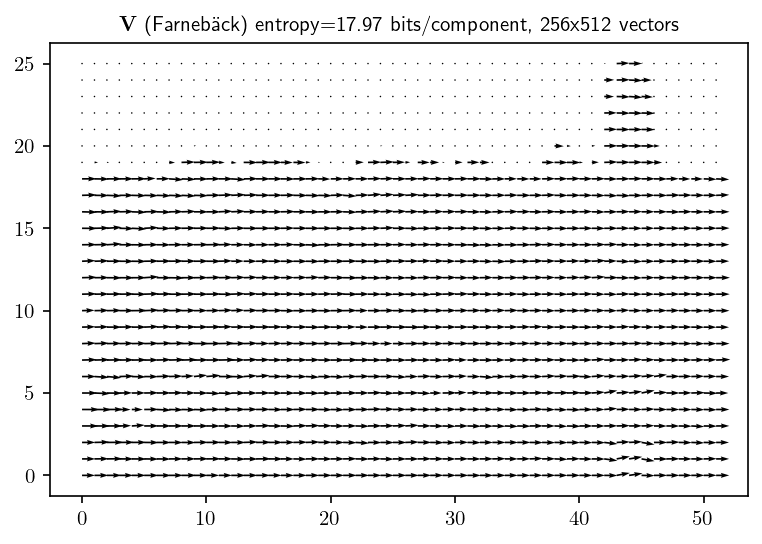

In [45]:
entropy = information.entropy(MVs.flatten())
display.show_vectors(MVs[::10, ::10], title="${\mathbf V}$ (Farnebäck) " + f"entropy={entropy:1.2f} bits/component" + f", {MVs.shape[0]}x{MVs.shape[1]} vectors")

[image_3.py:87 print_stats() INFO] component=0 max=254 min=0 avg=108.20100402832031
[image_3.py:87 print_stats() INFO] component=1 max=243 min=0 avg=93.01155090332031
[image_3.py:87 print_stats() INFO] component=2 max=232 min=0 avg=76.66618347167969
[image_3.py:87 print_stats() INFO] component=0 max=227 min=10 avg=127.9944076538086
[image_3.py:87 print_stats() INFO] component=1 max=248 min=43 avg=128.05745697021484
[image_3.py:87 print_stats() INFO] component=2 max=244 min=69 avg=127.90385437011719


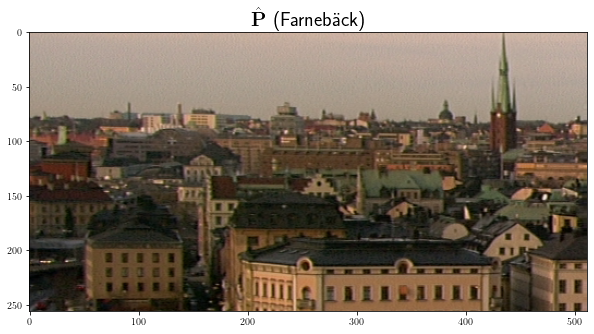

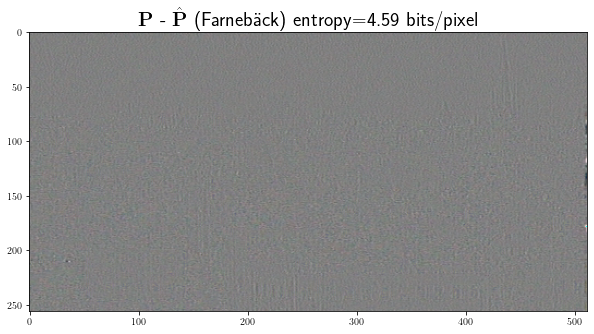

In [46]:
hat_P = prediction.make(R, MVs)
RGB_image.show(hat_P, "$\hat{\mathbf P}$ (Farnebäck)")
P_hat_P = P - hat_P + 128
entropy = information.entropy(P_hat_P.flatten())
RGB_image.show(P_hat_P.astype(np.uint8), "${\mathbf P}$ - $\hat{\mathbf P}$ (Farnebäck)" + f" entropy={entropy:1.2f} bits/pixel")

Notice that Farneback provides subpixel accuracy.

## Another implementation
https://github.com/ericPrince/optical-flow/blob/master/optical_flow.py

In [47]:
import numpy as np
import scipy.ndimage
from functools import partial
import skimage.io
import skimage.transform

__all__ = ["__version__", "poly_exp", "flow_iterative"]


__version__ = "1.0.0"


def poly_exp(f, c, sigma):
    """
    Calculates the local polynomial expansion of a 2D signal, as described by Farneback
    Uses separable normalized correlation
    $f ~ x^T A x + B^T x + C$
    If f[i, j] and c[i, j] are the signal value and certainty of pixel (i, j) then
    A[i, j] is a 2x2 array representing the quadratic term of the polynomial, B[i, j]
    is a 2-element array representing the linear term, and C[i, j] is a scalar
    representing the constant term.
    Parameters
    ----------
    f
        Input signal
    c
        Certainty of signal
    sigma
        Standard deviation of applicability Gaussian kernel
    Returns
    -------
    A
        Quadratic term of polynomial expansion
    B
        Linear term of polynomial expansion
    C
        Constant term of polynomial expansion
    """
    # Calculate applicability kernel (1D because it is separable)
    n = int(4 * sigma + 1)
    print("n =", n)
    x = np.arange(-n, n + 1, dtype=np.int32)
    print("x =", )
    a = np.exp(-(x**2) / (2 * sigma**2))  # a: applicability kernel [n]
    print("a =", a)

    # b: calculate b from the paper. Calculate separately for X and Y dimensions
    # [n, 6]
    bx = np.stack(
        [np.ones(a.shape), x, np.ones(a.shape), x**2, np.ones(a.shape), x], axis=-1
    )
    print("bx =", bx)
    by = np.stack(
        [
            np.ones(a.shape),
            np.ones(a.shape),
            x,
            np.ones(a.shape),
            x**2,
            x,
        ],
        axis=-1,
    )
    print("by =", by)

    # Pre-calculate product of certainty and signal
    cf = c * f
    print("c =", c)
    print("f =", f)
    print("cf =", cf)

    # G and v are used to calculate "r" from the paper: v = G*r
    # r is the parametrization of the 2nd order polynomial for f
    G = np.empty(list(f.shape) + [bx.shape[-1]] * 2)
    v = np.empty(list(f.shape) + [bx.shape[-1]])
    print("G.shape =", G.shape)
    print("v.shape =", v.shape)

    # Apply separable cross-correlations

    # Pre-calculate quantities recommended in paper
    ab = np.einsum("i,ij->ij", a, bx)
    abb = np.einsum("ij,ik->ijk", ab, bx)
    print("ab =", ab)
    print("abb =", abb)

    # Calculate G and v for each pixel with cross-correlation
    for i in range(bx.shape[-1]):
        for j in range(bx.shape[-1]):
            G[..., i, j] = scipy.ndimage.correlate1d(
                c, abb[..., i, j], axis=0, mode="constant", cval=0
            )

        v[..., i] = scipy.ndimage.correlate1d(
            cf, ab[..., i], axis=0, mode="constant", cval=0
        )

    # Pre-calculate quantities recommended in paper
    ab = np.einsum("i,ij->ij", a, by)
    abb = np.einsum("ij,ik->ijk", ab, by)
    print("ab =", ab)
    print("abb =", abb)

    # Calculate G and v for each pixel with cross-correlation
    for i in range(bx.shape[-1]):
        for j in range(bx.shape[-1]):
            G[..., i, j] = scipy.ndimage.correlate1d(
                G[..., i, j], abb[..., i, j], axis=1, mode="constant", cval=0
            )

        v[..., i] = scipy.ndimage.correlate1d(
            v[..., i], ab[..., i], axis=1, mode="constant", cval=0
        )

    # Solve r for each pixel
    r = np.linalg.solve(G, v)

    # Quadratic term
    A = np.empty(list(f.shape) + [2, 2])
    A[..., 0, 0] = r[..., 3]
    A[..., 0, 1] = r[..., 5] / 2
    A[..., 1, 0] = A[..., 0, 1]
    A[..., 1, 1] = r[..., 4]

    # Linear term
    B = np.empty(list(f.shape) + [2])
    B[..., 0] = r[..., 1]
    B[..., 1] = r[..., 2]

    # constant term
    C = r[..., 0]

    # b: [n, n, 6]
    # r: [f, f, 6]
    # f: [f, f]
    # e = b*r - f
    print("A =", A)
    print("B =", B)
    print("C =", C)
    print("A.shape, B.shape, C.shape =", A.shape, B.shape, C.shape)

    return A, B, C


def flow_iterative(
    f1, f2, sigma, c1, c2, sigma_flow, num_iter=1, d=None, model="constant", mu=None
):
    """
    Calculates optical flow with an algorithm described by Gunnar Farneback
    Parameters
    ----------
    f1
        First image
    f2
        Second image
    sigma
        Polynomial expansion applicability Gaussian kernel sigma
    c1
        Certainty of first image
    c2
        Certainty of second image
    sigma_flow
        Applicability window Gaussian kernel sigma for polynomial matching
    num_iter
        Number of iterations to run (defaults to 1)
    d: (optional)
        Initial displacement field
    p: (optional)
        Initial global displacement model parameters
    model: ['constant', 'affine', 'eight_param']
        Optical flow parametrization to use
    mu: (optional)
        Weighting term for usage of global parametrization. Defaults to
        using value recommended in Farneback's thesis
    Returns
    -------
    d
        Optical flow field. d[i, j] is the (y, x) displacement for pixel (i, j)
    """

    # TODO: add initial warp parameters as optional input?

    # Calculate the polynomial expansion at each point in the images
    A1, B1, C1 = poly_exp(f1, c1, sigma)
    A2, B2, C2 = poly_exp(f2, c2, sigma)

    # Pixel coordinates of each point in the images
    x = np.stack(
        np.broadcast_arrays(np.arange(f1.shape[0])[:, None], np.arange(f1.shape[1])),
        axis=-1,
    ).astype(np.int32)

    # Initialize displacement field
    if d is None:
        d = np.zeros(list(f1.shape) + [2])

    # Set up applicability convolution window
    n_flow = int(4 * sigma_flow + 1)
    xw = np.arange(-n_flow, n_flow + 1)
    w = np.exp(-(xw**2) / (2 * sigma_flow**2))

    # Evaluate warp parametrization model at pixel coordinates
    if model == "constant":
        S = np.eye(2)

    elif model in ("affine", "eight_param"):
        S = np.empty(list(x.shape) + [6 if model == "affine" else 8])

        S[..., 0, 0] = 1
        S[..., 0, 1] = x[..., 0]
        S[..., 0, 2] = x[..., 1]
        S[..., 0, 3] = 0
        S[..., 0, 4] = 0
        S[..., 0, 5] = 0

        S[..., 1, 0] = 0
        S[..., 1, 1] = 0
        S[..., 1, 2] = 0
        S[..., 1, 3] = 1
        S[..., 1, 4] = x[..., 0]
        S[..., 1, 5] = x[..., 1]

        if model == "eight_param":
            S[..., 0, 6] = x[..., 0] ** 2
            S[..., 0, 7] = x[..., 0] * x[..., 1]

            S[..., 1, 6] = x[..., 0] * x[..., 1]
            S[..., 1, 7] = x[..., 1] ** 2

    else:
        raise ValueError("Invalid parametrization model")

    S_T = S.swapaxes(-1, -2)

    # Iterate convolutions to estimate the optical flow
    for _ in range(num_iter):
        # Set d~ as displacement field fit to nearest pixel (and constrain to not
        # being off image). Note we are setting certainty to 0 for points that
        # would have been off-image had we not constrained them
        d_ = d.astype(np.int32)
        x_ = x + d_

        # x_ = np.maximum(np.minimum(x_, np.array(f1.shape) - 1), 0)

        # Constrain d~ to be on-image, and find points that would have
        # been off-image
        x_2 = np.maximum(np.minimum(x_, np.array(f1.shape) - 1), 0)
        off_f = np.any(x_ != x_2, axis=-1)
        x_ = x_2

        # Set certainty to 0 for off-image points
        c_ = c1[x_[..., 0], x_[..., 1]]
        c_[off_f] = 0

        # Calculate A and delB for each point, according to paper
        A = (A1 + A2[x_[..., 0], x_[..., 1]]) / 2
        A *= c_[
            ..., None, None
        ]  # recommendation in paper: add in certainty by applying to A and delB

        delB = -1 / 2 * (B2[x_[..., 0], x_[..., 1]] - B1) + (A @ d_[..., None])[..., 0]
        delB *= c_[
            ..., None
        ]  # recommendation in paper: add in certainty by applying to A and delB

        # Pre-calculate quantities recommended by paper
        A_T = A.swapaxes(-1, -2)
        ATA = S_T @ A_T @ A @ S
        ATb = (S_T @ A_T @ delB[..., None])[..., 0]
        # btb = delB.swapaxes(-1, -2) @ delB

        # If mu is 0, it means the global/average parametrized warp should not be
        # calculated, and the parametrization should apply to the local calculations
        if mu == 0:
            # Apply separable cross-correlation to calculate linear equation
            # for each pixel: G*d = h
            G = scipy.ndimage.correlate1d(ATA, w, axis=0, mode="constant", cval=0)
            G = scipy.ndimage.correlate1d(G, w, axis=1, mode="constant", cval=0)

            h = scipy.ndimage.correlate1d(ATb, w, axis=0, mode="constant", cval=0)
            h = scipy.ndimage.correlate1d(h, w, axis=1, mode="constant", cval=0)

            d = (S @ np.linalg.solve(G, h)[..., None])[..., 0]

        # 
        # and "force" the background warp onto uncertain pixels
        else:
            # Calculate global parametrized warp
            G_avg = np.mean(ATA, axis=(0, 1))
            h_avg = np.mean(ATb, axis=(0, 1))
            p_avg = np.linalg.solve(G_avg, h_avg)
            d_avg = (S @ p_avg[..., None])[..., 0]

            # Default value for mu is to set mu to 1/2 the trace of G_avg
            if mu is None:
          
                mu = 1 / 2 * np.trace(G_avg)

            # Apply separable cross-correlation to calculate linear equation
            G = scipy.ndimage.correlate1d(A_T @ A, w, axis=0, mode="constant", cval=0)
            G = scipy.ndimage.correlate1d(G, w, axis=1, mode="constant", cval=0)

            h = scipy.ndimage.correlate1d(
                (A_T @ delB[..., None])[..., 0], w, axis=0, mode="constant", cval=0
            )
            h = scipy.ndimage.correlate1d(h, w, axis=1, mode="constant", cval=0)

            # Refine estimate of displacement field
            d = np.linalg.solve(G + mu * np.eye(2), h + mu * d_avg)

    # TODO: return global displacement parameters and/or global displacement if mu != 0

    return d

def OF(f1, f2): # f1 and f2 double's
    # certainties for images - certainty is decreased for pixels near the edge
    # of the image, as recommended by Farneback

    # c1 = np.ones_like(f1)
    # c2 = np.ones_like(f2)

    c1 = np.minimum(
        1, 1 / 5 * np.minimum(np.arange(f1.shape[0])[:, None], np.arange(f1.shape[1]))
    )
    c1 = np.minimum(
        c1,
        1
        / 5
        * np.minimum(
            f1.shape[0] - 1 - np.arange(f1.shape[0])[:, None],
            f1.shape[1] - 1 - np.arange(f1.shape[1]),
        ),
    )
    c2 = c1

    # ---------------------------------------------------------------
    # calculate optical flow with this algorithm
    # ---------------------------------------------------------------

    n_pyr = 4

    # # version using perspective warp regularization
    # # to clean edges
    # opts = dict(
    #     sigma=4.0,
    #     sigma_flow=4.0,
    #     num_iter=3,
    #     model='eight_param',
    #     mu=None,
    # )

    # version using no regularization model
    opts = dict(
        sigma=4.0,
        sigma_flow=4.0,
        num_iter=3,
        model="constant",
        mu=0,
    )

    # optical flow field
    d = None

    # calculate optical flow using pyramids
    # note: reversed(...) because we start with the smallest pyramid
    for pyr1, pyr2, c1_, c2_ in reversed(
        list(
            zip(
                *list(
                    map(
                        partial(skimage.transform.pyramid_gaussian, max_layer=n_pyr),
                        [f1, f2, c1, c2],
                    )
                )
            )
        )
    ):
        if d is not None:
            # TODO: account for shapes not quite matching
            #d = skimage.transform.pyramid_expand(d, multichannel=True)
            d = skimage.transform.pyramid_expand(d, channel_axis=2)
            d = d[: pyr1.shape[0], : pyr2.shape[1]]

        d = flow_iterative(pyr1, pyr2, c1=c1_, c2=c2_, d=d, **opts)

    xw = d + np.moveaxis(np.indices(f1.shape), 0, -1)
    return xw

In [48]:
MVs = OF(P_Y, R_Y)
f2_w = skimage.transform.warp(R_Y, np.moveaxis(MVs, -1, 0), cval=np.nan)

n = 17
x =
a = [1.19612884e-04 3.35462628e-04 8.83826307e-04 2.18749112e-03
 5.08606923e-03 1.11089965e-02 2.27941809e-02 4.39369336e-02
 7.95595087e-02 1.35335283e-01 2.16265167e-01 3.24652467e-01
 4.57833362e-01 6.06530660e-01 7.54839602e-01 8.82496903e-01
 9.69233234e-01 1.00000000e+00 9.69233234e-01 8.82496903e-01
 7.54839602e-01 6.06530660e-01 4.57833362e-01 3.24652467e-01
 2.16265167e-01 1.35335283e-01 7.95595087e-02 4.39369336e-02
 2.27941809e-02 1.11089965e-02 5.08606923e-03 2.18749112e-03
 8.83826307e-04 3.35462628e-04 1.19612884e-04]
bx = [[  1. -17.   1. 289.   1. -17.]
 [  1. -16.   1. 256.   1. -16.]
 [  1. -15.   1. 225.   1. -15.]
 [  1. -14.   1. 196.   1. -14.]
 [  1. -13.   1. 169.   1. -13.]
 [  1. -12.   1. 144.   1. -12.]
 [  1. -11.   1. 121.   1. -11.]
 [  1. -10.   1. 100.   1. -10.]
 [  1.  -9.   1.  81.   1.  -9.]
 [  1.  -8.   1.  64.   1.  -8.]
 [  1.  -7.   1.  49.   1.  -7.]
 [  1.  -6.   1.  36.   1.  -6.]
 [  1.  -5.   1.  25.   1.  -5.]
 [  1.  -4.   1.

ab = [[ 1.19612884e-04  1.19612884e-04 -2.03341902e-03  1.19612884e-04
   3.45681234e-02 -2.03341902e-03]
 [ 3.35462628e-04  3.35462628e-04 -5.36740205e-03  3.35462628e-04
   8.58784327e-02 -5.36740205e-03]
 [ 8.83826307e-04  8.83826307e-04 -1.32573946e-02  8.83826307e-04
   1.98860919e-01 -1.32573946e-02]
 [ 2.18749112e-03  2.18749112e-03 -3.06248757e-02  2.18749112e-03
   4.28748259e-01 -3.06248757e-02]
 [ 5.08606923e-03  5.08606923e-03 -6.61189000e-02  5.08606923e-03
   8.59545700e-01 -6.61189000e-02]
 [ 1.11089965e-02  1.11089965e-02 -1.33307958e-01  1.11089965e-02
   1.59969550e+00 -1.33307958e-01]
 [ 2.27941809e-02  2.27941809e-02 -2.50735990e-01  2.27941809e-02
   2.75809589e+00 -2.50735990e-01]
 [ 4.39369336e-02  4.39369336e-02 -4.39369336e-01  4.39369336e-02
   4.39369336e+00 -4.39369336e-01]
 [ 7.95595087e-02  7.95595087e-02 -7.16035578e-01  7.95595087e-02
   6.44432021e+00 -7.16035578e-01]
 [ 1.35335283e-01  1.35335283e-01 -1.08268227e+00  1.35335283e-01
   8.66145813e+00 -1

n = 17
x =
a = [1.19612884e-04 3.35462628e-04 8.83826307e-04 2.18749112e-03
 5.08606923e-03 1.11089965e-02 2.27941809e-02 4.39369336e-02
 7.95595087e-02 1.35335283e-01 2.16265167e-01 3.24652467e-01
 4.57833362e-01 6.06530660e-01 7.54839602e-01 8.82496903e-01
 9.69233234e-01 1.00000000e+00 9.69233234e-01 8.82496903e-01
 7.54839602e-01 6.06530660e-01 4.57833362e-01 3.24652467e-01
 2.16265167e-01 1.35335283e-01 7.95595087e-02 4.39369336e-02
 2.27941809e-02 1.11089965e-02 5.08606923e-03 2.18749112e-03
 8.83826307e-04 3.35462628e-04 1.19612884e-04]
bx = [[  1. -17.   1. 289.   1. -17.]
 [  1. -16.   1. 256.   1. -16.]
 [  1. -15.   1. 225.   1. -15.]
 [  1. -14.   1. 196.   1. -14.]
 [  1. -13.   1. 169.   1. -13.]
 [  1. -12.   1. 144.   1. -12.]
 [  1. -11.   1. 121.   1. -11.]
 [  1. -10.   1. 100.   1. -10.]
 [  1.  -9.   1.  81.   1.  -9.]
 [  1.  -8.   1.  64.   1.  -8.]
 [  1.  -7.   1.  49.   1.  -7.]
 [  1.  -6.   1.  36.   1.  -6.]
 [  1.  -5.   1.  25.   1.  -5.]
 [  1.  -4.   1.

c = [[0.05282831 0.11927112 0.12209635 ... 0.12209635 0.11927112 0.05282831]
 [0.11927112 0.41146256 0.49717452 ... 0.49717452 0.41146256 0.11927112]
 [0.12209635 0.49717452 0.80930156 ... 0.80930156 0.49717452 0.12209635]
 ...
 [0.12209635 0.49717452 0.80930156 ... 0.80930156 0.49717452 0.12209635]
 [0.11927112 0.41146256 0.49717452 ... 0.49717452 0.41146256 0.11927112]
 [0.05282831 0.11927112 0.12209635 ... 0.12209635 0.11927112 0.05282831]]
f = [[0.00520461 0.00520317 0.00527227 ... 0.00562936 0.00558607 0.00566387]
 [0.00522324 0.00521565 0.00524469 ... 0.00560365 0.00559065 0.00556658]
 [0.00513586 0.00515386 0.00516421 ... 0.00558605 0.00556118 0.00555192]
 ...
 [0.00101936 0.00119057 0.00149115 ... 0.00090247 0.00239018 0.00399889]
 [0.00144433 0.00185076 0.00230907 ... 0.00089585 0.00240915 0.00403487]
 [0.00163518 0.00240984 0.0022646  ... 0.00097655 0.00263401 0.00386991]]
cf = [[2.74950685e-04 6.20588290e-04 6.43725462e-04 ... 6.87324092e-04
  6.66256681e-04 2.99212878e-04]


A = [[[[ 1.45547831e-06 -2.59666299e-07]
   [-2.59666299e-07 -2.56020821e-07]]

  [[ 1.48568408e-06 -2.29575749e-07]
   [-2.29575749e-07 -2.33214888e-07]]

  [[ 1.52037501e-06 -2.05485015e-07]
   [-2.05485015e-07 -1.93104290e-07]]

  ...

  [[ 1.25396731e-06  2.53412742e-07]
   [ 2.53412742e-07  7.27387912e-09]]

  [[ 1.22128581e-06  3.12965019e-07]
   [ 3.12965019e-07 -2.10784467e-08]]

  [[ 1.19130743e-06  3.81660550e-07]
   [ 3.81660550e-07 -7.29524822e-08]]]


 [[[ 1.37762763e-06 -2.27594601e-07]
   [-2.27594601e-07 -2.20389512e-07]]

  [[ 1.40348480e-06 -1.98749709e-07]
   [-1.98749709e-07 -2.05179268e-07]]

  [[ 1.43233917e-06 -1.74494348e-07]
   [-1.74494348e-07 -1.72166262e-07]]

  ...

  [[ 1.62454798e-06  2.31498516e-07]
   [ 2.31498516e-07  4.58148697e-08]]

  [[ 1.58873029e-06  2.88515602e-07]
   [ 2.88515602e-07  3.09573074e-08]]

  [[ 1.55375689e-06  3.55385318e-07]
   [ 3.55385318e-07 -7.14322195e-09]]]


 [[[ 1.29041697e-06 -1.96811647e-07]
   [-1.96811647e-07 -1.825901

ab = [[ 1.19612884e-04  1.19612884e-04 -2.03341902e-03  1.19612884e-04
   3.45681234e-02 -2.03341902e-03]
 [ 3.35462628e-04  3.35462628e-04 -5.36740205e-03  3.35462628e-04
   8.58784327e-02 -5.36740205e-03]
 [ 8.83826307e-04  8.83826307e-04 -1.32573946e-02  8.83826307e-04
   1.98860919e-01 -1.32573946e-02]
 [ 2.18749112e-03  2.18749112e-03 -3.06248757e-02  2.18749112e-03
   4.28748259e-01 -3.06248757e-02]
 [ 5.08606923e-03  5.08606923e-03 -6.61189000e-02  5.08606923e-03
   8.59545700e-01 -6.61189000e-02]
 [ 1.11089965e-02  1.11089965e-02 -1.33307958e-01  1.11089965e-02
   1.59969550e+00 -1.33307958e-01]
 [ 2.27941809e-02  2.27941809e-02 -2.50735990e-01  2.27941809e-02
   2.75809589e+00 -2.50735990e-01]
 [ 4.39369336e-02  4.39369336e-02 -4.39369336e-01  4.39369336e-02
   4.39369336e+00 -4.39369336e-01]
 [ 7.95595087e-02  7.95595087e-02 -7.16035578e-01  7.95595087e-02
   6.44432021e+00 -7.16035578e-01]
 [ 1.35335283e-01  1.35335283e-01 -1.08268227e+00  1.35335283e-01
   8.66145813e+00 -1

ab = [[ 1.19612884e-04  1.19612884e-04 -2.03341902e-03  1.19612884e-04
   3.45681234e-02 -2.03341902e-03]
 [ 3.35462628e-04  3.35462628e-04 -5.36740205e-03  3.35462628e-04
   8.58784327e-02 -5.36740205e-03]
 [ 8.83826307e-04  8.83826307e-04 -1.32573946e-02  8.83826307e-04
   1.98860919e-01 -1.32573946e-02]
 [ 2.18749112e-03  2.18749112e-03 -3.06248757e-02  2.18749112e-03
   4.28748259e-01 -3.06248757e-02]
 [ 5.08606923e-03  5.08606923e-03 -6.61189000e-02  5.08606923e-03
   8.59545700e-01 -6.61189000e-02]
 [ 1.11089965e-02  1.11089965e-02 -1.33307958e-01  1.11089965e-02
   1.59969550e+00 -1.33307958e-01]
 [ 2.27941809e-02  2.27941809e-02 -2.50735990e-01  2.27941809e-02
   2.75809589e+00 -2.50735990e-01]
 [ 4.39369336e-02  4.39369336e-02 -4.39369336e-01  4.39369336e-02
   4.39369336e+00 -4.39369336e-01]
 [ 7.95595087e-02  7.95595087e-02 -7.16035578e-01  7.95595087e-02
   6.44432021e+00 -7.16035578e-01]
 [ 1.35335283e-01  1.35335283e-01 -1.08268227e+00  1.35335283e-01
   8.66145813e+00 -1

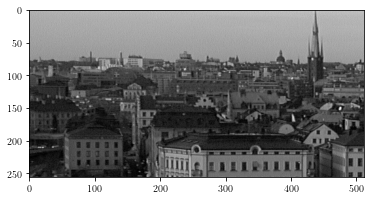

In [49]:
cmap = "gray"
plt.imshow(R_Y, cmap=cmap)

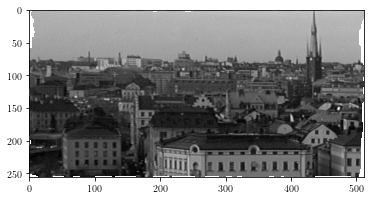

In [50]:
plt.imshow(f2_w, cmap=cmap)

## Working with lines
Farneback requires at least 2 lines, that in this case are true lines extracted from the image.

In [51]:
R = RGB_image.read(sequence + "003.png")[100:356,100:103]
P = RGB_image.read(sequence + "003.png")[100:356,104:107]

[image_3.py:39 read() INFO] /tmp/original_003.png (768, 1280, 3) uint8 len=1927644 max=255 min=0
[image_3.py:39 read() INFO] /tmp/original_003.png (768, 1280, 3) uint8 len=1927644 max=255 min=0


In [52]:
R.shape

(256, 3, 3)

In [53]:
P.shape

(256, 3, 3)

In [54]:
R_Y = YUV.from_RGB(R.astype(np.int16))[...,0]
P_Y = YUV.from_RGB(P.astype(np.int16))[...,0]

In [55]:
print(R_Y, P_Y)

[[168 177 171]
 [167 170 167]
 [170 176 177]
 [168 175 167]
 [167 170 168]
 [164 169 169]
 [171 175 172]
 [167 166 167]
 [169 166 171]
 [171 168 168]
 [164 170 167]
 [164 170 169]
 [167 167 168]
 [164 164 173]
 [162 163 168]
 [168 167 162]
 [168 167 164]
 [164 170 163]
 [168 164 155]
 [162 164 161]
 [162 163 168]
 [165 161 164]
 [165 158 165]
 [161 164 162]
 [161 159 164]
 [160 164 160]
 [160 162 160]
 [162 163 167]
 [163 164 160]
 [162 169 162]
 [160 162 156]
 [163 157 156]
 [164 167 160]
 [154 161 158]
 [162 162 158]
 [158 160 162]
 [162 161 153]
 [157 157 164]
 [157 160 157]
 [158 149 160]
 [161 164 156]
 [160 158 154]
 [158 158 154]
 [158 156 154]
 [151 161 157]
 [153 154 167]
 [157 156 161]
 [153 158 160]
 [158 158 158]
 [154 155 160]
 [161 155 154]
 [163 154 146]
 [158 157 150]
 [153 153 150]
 [154 146 157]
 [156 147 151]
 [150 149 151]
 [150 154 146]
 [146 150 152]
 [153 149 147]
 [150 148 150]
 [143 156 152]
 [148 155 154]
 [154 155 147]
 [149 148 148]
 [147 148 149]
 [152 148 

In [56]:
initial_MVs = np.zeros((P_Y.shape[0], P_Y.shape[1], 2), dtype=np.float32)
MVs = motion.Farneback_ME(predicted=P_Y, reference=R_Y, initial_MVs=initial_MVs, wside=3)

In [57]:
print(np.max(MVs), np.min(MVs))

0.50213027 -1.3140426


## Working with 1-d lines

In [58]:
R_Y_line = R_Y[..., 1]
P_Y_line = P_Y[..., 2]

In [59]:
print(R_Y_line.shape,P_Y_line.shape)

(256,) (256,)


In [60]:
R = np.stack([np.roll(R_Y_line,-1), R_Y_line, np.roll(R_Y_line,1)])
P = np.stack([np.roll(P_Y_line,-1), P_Y_line, np.roll(P_Y_line,1)])

In [61]:
print(R.shape, P.shape)

(3, 256) (3, 256)


In [62]:
for i in range(10):
    print(R[0, i], R[1, i])

170 177
176 170
175 176
170 175
169 170
175 169
166 175
166 166
168 166
170 168


In [63]:
for i in range(10):
    print(P[0, i], P[1, i])

170 171
171 170
175 171
168 175
170 168
172 170
167 172
168 167
163 168
162 163


In [64]:
for i in range(10):
    print(R[0, i], P[1, i])

170 171
176 170
175 171
170 175
169 168
175 170
166 172
166 167
168 168
170 163


In [65]:
initial_MVs = np.zeros((P.shape[0], P.shape[1], 2), dtype=np.float32)
MVs = motion.Farneback_ME(predicted=P, reference=R, initial_MVs=initial_MVs, wside=3)

In [66]:
#print(np.max(MVs[1]), np.min(MVs[1]), np.argmax(MVs[1]), MVs[np.argmax(MVs[1])])
print(np.max(MVs[1]), np.min(MVs[1]), len(MVs[1]), np.argmax(MVs[1]))

0.0024045934 -0.0005961855 256 422


In [67]:
for i in range(P.shape[1]):
    print(i, R[1, i], P[1, i], MVs[1, i])

0 177 171 [-4.2747388e-07  6.3140499e-07]
1 170 170 [-1.1069873e-07  1.2621368e-07]
2 176 171 [-3.7129923e-06  2.0753462e-06]
3 175 175 [-1.5921353e-07  4.4808569e-08]
4 170 168 [-5.441586e-10  8.860330e-10]
5 169 170 [-6.060322e-10 -3.121932e-10]
6 175 172 [1.5024436e-09 2.6104976e-09]
7 166 167 [-6.0395085e-11 -7.8965709e-11]
8 166 168 [-2.9122099e-08  2.8965914e-09]
9 168 163 [-3.3439104e-08  4.7375468e-09]
10 170 162 [-2.5576496e-10  1.2058695e-09]
11 170 162 [-7.7666762e-10  6.0661063e-09]
12 167 169 [-1.9422770e-09  8.0615026e-10]
13 164 163 [-8.7087067e-11 -2.1556648e-09]
14 163 166 [-1.0678195e-09  5.2118965e-10]
15 167 164 [ 2.4457028e-10 -1.5284167e-10]
16 167 164 [ 3.3596455e-09 -9.5268182e-10]
17 170 160 [-2.5016850e-10  3.8770812e-10]
18 164 164 [ 7.320764e-10 -2.860575e-09]
19 164 160 [ 5.6345634e-10 -1.5352182e-09]
20 163 167 [-4.8322764e-09  2.8713767e-09]
21 161 167 [3.8836229e-10 3.0772023e-09]
22 158 163 [-4.5094103e-10  1.1588202e-10]
23 164 160 [-1.6419996e-08  2.3

208 42 64 [-4.7919643e-06  1.2181298e-06]
209 50 83 [ 1.3521497e-05 -9.4288982e-05]
210 30 58 [1.1893730e-03 2.0437037e-05]
211 181 55 [ 0.00240459 -0.00020387]
212 115 28 [-3.5800786e-05  1.0401639e-05]
213 26 1 [ 0.00025577 -0.00059619]
214 32 13 [ 0.00098423 -0.00023035]
215 54 48 [ 1.5822206e-05 -1.1825105e-05]
216 48 45 [-1.7370623e-05  1.4478646e-05]
217 51 48 [2.4424221e-06 1.4884735e-05]
218 40 49 [1.6519656e-05 5.3298213e-06]
219 49 27 [ 1.7216952e-06 -8.0671832e-08]
220 27 10 [ 6.2946384e-07 -3.4263089e-06]
221 6 11 [ 2.2635127e-06 -6.3675984e-06]
222 17 16 [3.3083239e-07 2.0327388e-07]
223 18 10 [ 7.4952515e-09 -3.5652648e-09]
224 10 2 [ 1.06017666e-07 -4.56371723e-08]
225 2 2 [ 6.150108e-07 -4.637041e-07]
226 6 9 [ 6.1207692e-07 -4.2299007e-08]
227 6 4 [1.9233372e-07 4.1208569e-08]
228 9 10 [5.7252613e-08 3.7459560e-10]
229 15 21 [ 2.21870010e-07 -1.45782355e-08]
230 12 9 [-4.3567628e-08 -1.3085264e-08]
231 11 22 [-1.4321927e-06  3.7079349e-07]
232 21 52 [ 2.5072254e-07 -2.

In [73]:
line = np.arange(4).astype(np.int16)
block = np.stack([line, line, line, line])
print(block)
#block = np.arange(16).astype(np.int16).reshape(4, 4)
c = np.ones_like(block)
A, B, C = poly_exp(block, c, sigma=1.0)

[[0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]]
n = 5
x =
a = [3.72665317e-06 3.35462628e-04 1.11089965e-02 1.35335283e-01
 6.06530660e-01 1.00000000e+00 6.06530660e-01 1.35335283e-01
 1.11089965e-02 3.35462628e-04 3.72665317e-06]
bx = [[ 1. -5.  1. 25.  1. -5.]
 [ 1. -4.  1. 16.  1. -4.]
 [ 1. -3.  1.  9.  1. -3.]
 [ 1. -2.  1.  4.  1. -2.]
 [ 1. -1.  1.  1.  1. -1.]
 [ 1.  0.  1.  0.  1.  0.]
 [ 1.  1.  1.  1.  1.  1.]
 [ 1.  2.  1.  4.  1.  2.]
 [ 1.  3.  1.  9.  1.  3.]
 [ 1.  4.  1. 16.  1.  4.]
 [ 1.  5.  1. 25.  1.  5.]]
by = [[ 1.  1. -5.  1. 25. -5.]
 [ 1.  1. -4.  1. 16. -4.]
 [ 1.  1. -3.  1.  9. -3.]
 [ 1.  1. -2.  1.  4. -2.]
 [ 1.  1. -1.  1.  1. -1.]
 [ 1.  1.  0.  1.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.]
 [ 1.  1.  2.  1.  4.  2.]
 [ 1.  1.  3.  1.  9.  3.]
 [ 1.  1.  4.  1. 16.  4.]
 [ 1.  1.  5.  1. 25.  5.]]
c = [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
f = [[0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]]
cf = [[0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]]
G.shape = (4, 4, 6

## Farneback 1D

In [69]:
def poly_exp_1D(f, c, sigma):
    """
    Calculates the local polynomial expansion of a 1D signal.
    
    $f ~ x^T A x + B^T x + C$
    
    If f[i] and c[i] are the signal value and certainty of pixel i then
    A[i] is a 1x1 array representing the quadratic term of the polynomial, B[i]
    is a 1-element array representing the linear term, and C[i] is a scalar
    representing the constant term.
    
    Parameters
    ----------
    f
        Input signal
    c
        Certainty of signal
    sigma
        Standard deviation of applicability Gaussian kernel
    Returns
    -------
    A
        Quadratic term of polynomial expansion
    B
        Linear term of polynomial expansion
    C
        Constant term of polynomial expansion
    """
    # Kernel applicability
    n = int(4 * sigma + 1)
    print("n =", n)
    x = np.arange(-n, n + 1, dtype=np.int32)
    print("x =", x)
    a = np.exp(-(x**2) / (2 * sigma**2))
    print("a =", a)

    # b: calculate b from the paper.
    b = np.stack([np.ones(a.shape), x, x**2], axis=-1)
    print("b =", b)

    # Pre-calculate product of certainty and signal
    cf = c * f
    print("f =", f)
    print("c =", c)
    print("cf =", cf)
    

    # G and v are used to calculate "r" from the paper: v = G*r
    # r is the parametrization of the 2nd order polynomial for f
    G = np.empty(list(f.shape) + [b.shape[-1]] * 2)
    v = np.empty(list(f.shape) + [b.shape[-1]])

    #G = np.empty(list(f.shape))
    #v = np.empty(list(f.shape))
    print("G.shape =", G.shape)
    print("v.shape =", v.shape)

    # Apply cross-correlation

    # Pre-calculate quantities recommended in paper
    ab = np.einsum("i,ij->ij", a, b) # a[i]*b[i,j] -> ab[i,j]
    abb = np.einsum("ij,ik->ijk", ab, b) # ab[i,j]*b[i,k] -> abb[i,j,k]
    print("ab =", ab)
    print("abb =", abb)

    # Calculate G and v for each pixel with cross-correlation
    for i in range(b.shape[-1]):
        for j in range(b.shape[-1]):
            G[..., i, j] = scipy.ndimage.correlate1d(
                c, abb[..., i, j], axis=0, mode="constant", cval=0
            )

        v[..., i] = scipy.ndimage.correlate1d(
            cf, ab[..., i], axis=0, mode="constant", cval=0
        )
    #for j in range(b.shape[-1]):
    #    G[..., j] = scipy.ndimage.correlate1d(
    #        c, abb[..., j], axis=0, mode="constant", cval=0
    #    )
    print("G =", G)
    print("v =", v)

    #v = scipy.ndimage.correlate1d(
    #    cf, ab, axis=0, mode="constant", cval=0
    #)

    # Solve r for each pixel
    r = np.linalg.solve(G, v)
    print("r =", r)

    # Quadratic term
    #A = np.empty(list(f.shape))
    A = np.empty(list(f.shape)  + [1])
    A[..., 0] = r[..., 2]
    print("A =", A)

    # Linear term
    #B = np.empty(list(f.shape))
    B = np.empty(list(f.shape) + [1])
    B[..., 0] = r[..., 1]
    print("B =", B)

    # constant term
    C = r[..., 0]
    print("C =", C)

    # b: [n, n, 6]
    # r: [f, f, 6]
    # f: [f, f]
    # e = b*r - f

    print("A.shape, B.shape, C.shape =", A.shape, B.shape, C.shape)
    return A, B, C


In [70]:
line = np.arange(4).astype(np.int16)
c = np.ones_like(line)
A, B, C = poly_exp_1D(line, c, sigma=1.0)

n = 5
x = [-5 -4 -3 -2 -1  0  1  2  3  4  5]
a = [3.72665317e-06 3.35462628e-04 1.11089965e-02 1.35335283e-01
 6.06530660e-01 1.00000000e+00 6.06530660e-01 1.35335283e-01
 1.11089965e-02 3.35462628e-04 3.72665317e-06]
b = [[ 1. -5. 25.]
 [ 1. -4. 16.]
 [ 1. -3.  9.]
 [ 1. -2.  4.]
 [ 1. -1.  1.]
 [ 1.  0.  0.]
 [ 1.  1.  1.]
 [ 1.  2.  4.]
 [ 1.  3.  9.]
 [ 1.  4. 16.]
 [ 1.  5. 25.]]
f = [0 1 2 3]
c = [1 1 1 1]
cf = [0 1 2 3]
G.shape = (4, 3, 3)
v.shape = (4, 3)
ab = [[ 3.72665317e-06 -1.86332659e-05  9.31663293e-05]
 [ 3.35462628e-04 -1.34185051e-03  5.36740205e-03]
 [ 1.11089965e-02 -3.33269896e-02  9.99809688e-02]
 [ 1.35335283e-01 -2.70670566e-01  5.41341133e-01]
 [ 6.06530660e-01 -6.06530660e-01  6.06530660e-01]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 6.06530660e-01  6.06530660e-01  6.06530660e-01]
 [ 1.35335283e-01  2.70670566e-01  5.41341133e-01]
 [ 1.11089965e-02  3.33269896e-02  9.99809688e-02]
 [ 3.35462628e-04  1.34185051e-03  5.36740205e-03]
 [ 3.72665317e-06

In [82]:
def flow_iterative_1D(
    f1, f2, sigma, c1, c2, sigma_flow, num_iter=1, d=None, model="constant", mu=None
):
    """
    Calculates optical flow with an algorithm described by Gunnar Farneback
    Parameters
    ----------
    f1
        First image
    f2
        Second image
    sigma
        Polynomial expansion applicability Gaussian kernel sigma
    c1
        Certainty of first image
    c2
        Certainty of second image
    sigma_flow
        Applicability window Gaussian kernel sigma for polynomial matching
    num_iter
        Number of iterations to run (defaults to 1)
    d: (optional)
        Initial displacement field
    p: (optional)
        Initial global displacement model parameters
    model: ['constant', 'affine', 'eight_param']
        Optical flow parametrization to use
    mu: (optional)
        Weighting term for usage of global parametrization. Defaults to
        using value recommended in Farneback's thesis
    Returns
    -------
    d
        Optical flow field. d[i, j] is the (y, x) displacement for pixel (i, j)
    """

    # TODO: add initial warp parameters as optional input?

    # Calculate the polynomial expansion at each point in the lines
    A1, B1, C1 = poly_exp_1D(f1, c1, sigma)
    A2, B2, C2 = poly_exp_1D(f2, c2, sigma)

    # Pixel coordinates of each point in the images
    x = np.arange(f1.shape[0]).astype(np.int32)

    # Initialize displacement field
    if d is None:
        d = np.zeros(list(f1.shape) + [1])

    # Set up applicability convolution window
    n_flow = int(4 * sigma_flow + 1)
    xw = np.arange(-n_flow, n_flow + 1)
    w = np.exp(-(xw**2) / (2 * sigma_flow**2))

    # Evaluate warp parametrization model at pixel coordinates
    if model == "constant":
        S = np.eye(2)

    elif model in ("affine", "eight_param"):
        S = np.empty(list(x.shape) + [6 if model == "affine" else 8])

        S[..., 0, 0] = 1
        S[..., 0, 1] = x[..., 0]
        S[..., 0, 2] = x[..., 1]
        S[..., 0, 3] = 0
        S[..., 0, 4] = 0
        S[..., 0, 5] = 0

        S[..., 1, 0] = 0
        S[..., 1, 1] = 0
        S[..., 1, 2] = 0
        S[..., 1, 3] = 1
        S[..., 1, 4] = x[..., 0]
        S[..., 1, 5] = x[..., 1]

        if model == "eight_param":
            S[..., 0, 6] = x[..., 0] ** 2
            S[..., 0, 7] = x[..., 0] * x[..., 1]

            S[..., 1, 6] = x[..., 0] * x[..., 1]
            S[..., 1, 7] = x[..., 1] ** 2

    else:
        raise ValueError("Invalid parametrization model")

    S_T = S.swapaxes(-1, -2)

    # Iterate convolutions to estimate the optical flow
    for _ in range(num_iter):
        # Set d~ as displacement field fit to nearest pixel (and constrain to not
        # being off image). Note we are setting certainty to 0 for points that
        # would have been off-image had we not constrained them
        d_ = d.astype(np.int32)
        x_ = x + d_

        # x_ = np.maximum(np.minimum(x_, np.array(f1.shape) - 1), 0)

        # Constrain d~ to be on-image, and find points that would have
        # been off-image
        print(x_.shape, np.array(f1.shape))
        x_2 = np.maximum(np.minimum(x_, np.array(f1.shape) - 1), 0)
        off_f = np.any(x_ != x_2, axis=-1)
        x_ = x_2

        # Set certainty to 0 for off-image points
        c_ = c1[x_[..., 0], x_[..., 1]]
        c_[off_f] = 0

        # Calculate A and delB for each point, according to paper
        A = (A1 + A2[x_[..., 0], x_[..., 1]]) / 2
        A *= c_[
            ..., None, None
        ]  # recommendation in paper: add in certainty by applying to A and delB

        delB = -1 / 2 * (B2[x_[..., 0], x_[..., 1]] - B1) + (A @ d_[..., None])[..., 0]
        delB *= c_[
            ..., None
        ]  # recommendation in paper: add in certainty by applying to A and delB

        # Pre-calculate quantities recommended by paper
        A_T = A.swapaxes(-1, -2)
        ATA = S_T @ A_T @ A @ S
        ATb = (S_T @ A_T @ delB[..., None])[..., 0]
        # btb = delB.swapaxes(-1, -2) @ delB

        # If mu is 0, it means the global/average parametrized warp should not be
        # calculated, and the parametrization should apply to the local calculations
        if mu == 0:
            # Apply separable cross-correlation to calculate linear equation
            # for each pixel: G*d = h
            G = scipy.ndimage.correlate1d(ATA, w, axis=0, mode="constant", cval=0)
            G = scipy.ndimage.correlate1d(G, w, axis=1, mode="constant", cval=0)

            h = scipy.ndimage.correlate1d(ATb, w, axis=0, mode="constant", cval=0)
            h = scipy.ndimage.correlate1d(h, w, axis=1, mode="constant", cval=0)

            d = (S @ np.linalg.solve(G, h)[..., None])[..., 0]

        # 
        # and "force" the background warp onto uncertain pixels
        else:
            # Calculate global parametrized warp
            G_avg = np.mean(ATA, axis=(0, 1))
            h_avg = np.mean(ATb, axis=(0, 1))
            p_avg = np.linalg.solve(G_avg, h_avg)
            d_avg = (S @ p_avg[..., None])[..., 0]

            # Default value for mu is to set mu to 1/2 the trace of G_avg
            if mu is None:
                mu = 1 / 2 * np.trace(G_avg)

            # Apply separable cross-correlation to calculate linear equation
            G = scipy.ndimage.correlate1d(A_T @ A, w, axis=0, mode="constant", cval=0)
            G = scipy.ndimage.correlate1d(G, w, axis=1, mode="constant", cval=0)

            h = scipy.ndimage.correlate1d(
                (A_T @ delB[..., None])[..., 0], w, axis=0, mode="constant", cval=0
            )
            h = scipy.ndimage.correlate1d(h, w, axis=1, mode="constant", cval=0)

            # Refine estimate of displacement field
            d = np.linalg.solve(G + mu * np.eye(2), h + mu * d_avg)

    # TODO: return global displacement parameters and/or global displacement if mu != 0

    return d

In [83]:
f1 = np.arange(16).astype(np.int16).reshape(4, 4)
f2 = np.arange(16).astype(np.int16).reshape(4, 4)
sigma = 1.0
c1 = np.ones_like(f1)
c2 = np.ones_like(f2)
sigma_flow = 1.0
flow_iterative_1D(f1, f2, sigma, c1, c2, sigma_flow, num_iter=1, d=None, model="constant", mu=None)

n = 5
x = [-5 -4 -3 -2 -1  0  1  2  3  4  5]
a = [3.72665317e-06 3.35462628e-04 1.11089965e-02 1.35335283e-01
 6.06530660e-01 1.00000000e+00 6.06530660e-01 1.35335283e-01
 1.11089965e-02 3.35462628e-04 3.72665317e-06]
b = [[ 1. -5. 25.]
 [ 1. -4. 16.]
 [ 1. -3.  9.]
 [ 1. -2.  4.]
 [ 1. -1.  1.]
 [ 1.  0.  0.]
 [ 1.  1.  1.]
 [ 1.  2.  4.]
 [ 1.  3.  9.]
 [ 1.  4. 16.]
 [ 1.  5. 25.]]
f = [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
c = [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
cf = [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
G.shape = (4, 4, 3, 3)
v.shape = (4, 4, 3)
ab = [[ 3.72665317e-06 -1.86332659e-05  9.31663293e-05]
 [ 3.35462628e-04 -1.34185051e-03  5.36740205e-03]
 [ 1.11089965e-02 -3.33269896e-02  9.99809688e-02]
 [ 1.35335283e-01 -2.70670566e-01  5.41341133e-01]
 [ 6.06530660e-01 -6.06530660e-01  6.06530660e-01]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 6.06530660e-01  6.06530660e-01  6.06530660e-01]
 [ 1.35335283e-01  2.706705

ValueError: operands could not be broadcast together with shapes (4,4,4) (2,) 

In [75]:
f1 = np.arange(16).astype(np.int16).reshape(4, 4)
f2 = np.arange(16).astype(np.int16).reshape(4, 4)
x = np.stack(np.broadcast_arrays(np.arange(f1.shape[0])[:, None], np.arange(f1.shape[1])), axis=-1,).astype(np.int32)

In [76]:
print(x)

[[[0 0]
  [0 1]
  [0 2]
  [0 3]]

 [[1 0]
  [1 1]
  [1 2]
  [1 3]]

 [[2 0]
  [2 1]
  [2 2]
  [2 3]]

 [[3 0]
  [3 1]
  [3 2]
  [3 3]]]


In [78]:
np.eye(2).swapaxes(-1, -2)

array([[1., 0.],
       [0., 1.]])

In [71]:
c = np.ones_like(R_Y_line)
print(c.shape)
A, B, C = poly_exp_1D(R_Y_line, c, sigma=1.0)

(256,)
n = 5
x = [-5 -4 -3 -2 -1  0  1  2  3  4  5]
a = [3.72665317e-06 3.35462628e-04 1.11089965e-02 1.35335283e-01
 6.06530660e-01 1.00000000e+00 6.06530660e-01 1.35335283e-01
 1.11089965e-02 3.35462628e-04 3.72665317e-06]
b = [[ 1. -5. 25.]
 [ 1. -4. 16.]
 [ 1. -3.  9.]
 [ 1. -2.  4.]
 [ 1. -1.  1.]
 [ 1.  0.  0.]
 [ 1.  1.  1.]
 [ 1.  2.  4.]
 [ 1.  3.  9.]
 [ 1.  4. 16.]
 [ 1.  5. 25.]]
f = [177 170 176 175 170 169 175 166 166 168 170 170 167 164 163 167 167 170
 164 164 163 161 158 164 159 164 162 163 164 169 162 157 167 161 162 160
 161 157 160 149 164 158 158 156 161 154 156 158 158 155 155 154 157 153
 146 147 149 154 150 149 148 156 155 155 148 148 148 145 145 146 149 150
 152 145 139 141 141 133  96  60  70  63  65  70  69  62  61  57  82 143
 106  81  65  67  64  71  61  70  79  73  82  78  76  80  65  65  69  65
  61  54  58  62  55  66  56  51  64  43  53  51  49  23  28  45  42  31
  41  37  36  52  52  40  54  54  54  45  45  55  50  49  38  26   9  17
  24  24  21  25 

A = [[ 2.005e+02]
 [ 2.780e+01]
 [-5.000e+00]
 [-1.000e+00]
 [ 1.000e+00]
 [ 2.000e-01]
 [-1.200e+00]
 [ 6.000e-01]
 [ 1.200e+00]
 [ 0.000e+00]
 [-6.000e-01]
 [-1.000e+00]
 [ 0.000e+00]
 [ 1.000e+00]
 [ 1.000e+00]
 [-2.000e-01]
 [-6.000e-01]
 [-1.000e+00]
 [ 2.000e-01]
 [ 2.000e-01]
 [-2.000e-01]
 [ 6.000e-01]
 [ 8.000e-01]
 [-2.000e-01]
 [ 4.000e-01]
 [-2.000e-01]
 [ 2.000e-01]
 [ 4.000e-01]
 [-4.000e-01]
 [-1.600e+00]
 [ 6.000e-01]
 [ 1.600e+00]
 [-1.000e+00]
 [-4.000e-01]
 [ 2.000e-01]
 [ 0.000e+00]
 [-2.000e-01]
 [-2.000e-01]
 [ 4.000e-01]
 [ 1.800e+00]
 [-1.000e+00]
 [-8.000e-01]
 [ 6.000e-01]
 [ 2.000e-01]
 [-8.000e-01]
 [ 6.000e-01]
 [ 6.000e-01]
 [-4.000e-01]
 [-6.000e-01]
 [ 2.000e-01]
 [ 4.000e-01]
 [ 0.000e+00]
 [-1.200e+00]
 [-4.000e-01]
 [ 1.600e+00]
 [ 1.400e+00]
 [-2.000e-01]
 [-1.200e+00]
 [-2.000e-01]
 [ 1.000e+00]
 [ 1.000e+00]
 [-1.000e+00]
 [-1.400e+00]
 [-8.000e-01]
 [ 6.000e-01]
 [ 4.000e-01]
 [ 0.000e+00]
 [ 6.000e-01]
 [ 6.000e-01]
 [ 4.000e-01]
 [-4.000e-01]
 [

In [72]:
A_Y

NameError: name 'A_Y' is not defined

In [ ]:
A_Y.shape

In [ ]:
B_Y.shape

In [ ]:
C_Y.shape